In [2]:
import pandas as pd
import pylab as plt
import seaborn
import numpy as np
import re
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
%pylab inline
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import pickle as pickle
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

/ext/sage/sage-8.1/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


### Алгоритм F4

In [3]:
#  Implementation of the F4 Algorithm in Sage
#  [1]  Jean-Charles Faugere. A new efficient algorithm for computing Groebner bases (F4). Journal of pure and applied algebra, 139(1–3):61–88, July 1999.
#  [2]  Alessandro Giovini, Teo Mora, Gianfranco Niesi, Lorenzo Robbiano, Carlo Traverso. "One sugar cube, please "or Selection strategies in the Buchberger algorithm"".

########################################
#  Create a pair from two polynomials  #
########################################
#  [1] Definition 2.5, page 5

def Pair(f, g):
    try:
        lcm = (f.lm()).lcm(g.lm())
        return (lcm, lcm // f.lm(), f, lcm // g.lm(), g)
    except ZeroDivisionError:
        raise Exception()

########################################
#   Function adds new pairs to Pairs (f, g) where f belongs to new (set of polynomials),
#   g belongs to basis (temporary basis Gr. already found up to this point)
########################################

def FirstBuchbergerCriterion(f, g):
    if (f.lm()).gcd(g.lm()) == 1:
        return True
    return False

def SecondBuchbergerCriterion(f, g, basis, pairs):
    isReducible, h = IsTopReducible((f.lm()).lcm(g.lm()), basis)
    if isReducible:
        if Pair(f, h) in pairs and Pair(g, h) in pairs:
            return True
    return False

def BuchbergerCriteria(f, g, basis, Pairs):
    if FirstBuchbergerCriterion(f, g) and SecondBuchbergerCriterion(f, g, basis, pairs):
        return True
    return False

def Update(basis, pairs, new):
    try:
        basis += new
        basis = list(set(basis))
        for f in new:
            for g in basis:
                if f != g and Pair(g, f) not in pairs:
                    if not FirstBuchbergerCriterion(f, g):
                        pairs.append(Pair(f, g))
        result = [basis, pairs]
        return result
    except Exception:
        print "basis = ", basis

##############################################
#  Selection function - the normal strategy  #
##############################################
#  [1] function Sel, page 13

def LCM(pair):
    return pair[0]

def SelectionFunctionNormal(pairs):
    d = min([LCM(p).degree() for p in pairs])
    dPairs = [p for p in pairs if LCM(p).degree() == d]
    return dPairs

##############################################
#  Selection function - take all pairs  #
##############################################

def SelectionFunctionAll(pairs):
    return pairs

############################
#  Symbolic Preprocessing  #
############################
#  [1] Symbolic Preprocessing, page 7
#  for this procedure better see http://www.broune.com/papers/f4.pdf
#  page 2, instead of the original paper

def IsTopReducible(f, G):
    m = f.lm()
    for g in G:
        if g.lm().divides(m):
             return True, g
    return False, 0

def SymbolicPreprocessing(L, G):
    F = []
    for Li in L:
        F.append(Li[0] * Li[1])
    done = set([f.lt() for f in F])
    TF = set()
    for f in F:
        TF |= set(f.monomials())

    while len(TF) > 0:
        m = TF.pop()
        done.add(m)
        isReducible, f = IsTopReducible(m, G)
        if isReducible:
            mDash = m // f.lm()
            F.append(mDash * f)
            newMonomials = (mDash * f).monomials()
            newMonomials.remove(newMonomials[0])
            TF |= set(newMonomials)
            TF -= done
    return F

###############
#  Reduction  #
###############
#  [1] Reduction, page 6

def Reduction(L, G):
    F = SymbolicPreprocessing(L, G)

    leadingMonomials = set()
    for f in F:
        leadingMonomials.add(f.lm())

    monomials = set()
    for f in F:
        monomials |= set(f.monomials())

    monomials = list(monomials)
    monomials.sort(reverse = True)

    M = Matrix(len(F), len(monomials), lambda i, j: F[i].monomial_coefficient(monomials[j]), sparse = True)
    M.echelonize()
    polynomialsAfterEchelonize = []

    for i in range(M.nrows()):
        f = 0
        for j in range(M.ncols()):
            f += M[i, j] * monomials[j]
        if f != 0 and f.lm() not in leadingMonomials:
            polynomialsAfterEchelonize.append(f)

    return polynomialsAfterEchelonize, M.nrows() * M.ncols()

def IsReducible(f, F):
    if F == []:
        return False, 0
    f1 = f.reduce(F)
    if f1 != f:
        return True, f1
    return False, 0

def ReductionOfBasis(F):
    i = 0
    while i < len(F):
        if F[i] != 0:
            G = []
            for j in range (len(F)):
                if j != i:
                    if F[j] != 0:
                        G.append(F[j])
            (t, g) = IsReducible(F[i], G)
            if t:
                F[i] = g
                i = -1
        i += 1
    G = []
    for j in range (len(F)):
        if F[j] != 0:
            G.append(F[j] / F[j].lc())
    return G

#######################################
#  Main function of the F4 Algorithm  #
#######################################
#  [1] Algorithm F4, page 6

def F4(polynomials, strategy):
    (basis, pairs) = Update([], [], polynomials)
    howManySteps = 0

    while len(pairs):
        howManySteps += 1

        if (strategy == 'normal'):
            pairsSel = SelectionFunctionNormal(pairs)
        else:
            pairsSel = SelectionFunctionAll(pairs)
        pairs = list(set(pairs) - set(pairsSel))

        Ld = set()
        for pair in pairsSel:
            Ld.add((pair[1], pair[2]))
            Ld.add((pair[3], pair[4]))

        new, matrixSize = Reduction(Ld, basis)
        (basis, pairs) = Update(basis, pairs, new)

    return ReductionOfBasis(basis), howManySteps


def Spol(f, g):
    h = (f.lm()).lcm(g.lm())
    return g.lc() * h * f // f.lm() - f.lc() * h * g // g.lm()

def is_groebner_basis(G):
    if G == []:
        return False
    R = G[0].parent()
    for i in xrange(len(G)) :
        f = G[i]
        for j in xrange(i, len(G)) :
            g = G[j]
            if (Spol(f, g)).reduce(G) != R(0) :
                return False
    return True

def LaunchF4(n):
    for i in range (n):
        generators = GetRandomGeneratorsForIdeal(4, 4, 4)
        while 0 in generators:
            print "Zero in generators"
            generators = GetRandomGeneratorsForIdeal(4, 4, 4)
        basis, steps = F4(generators, 'normal')
        if not is_groebner_basis(basis):
            print "error, system = ", generators

### Работа с данными: первичный анализ

In [9]:
def Print(numOfObjects, i):
    if numOfObjects <= 30:
        print "Object No: ", i
    elif numOfObjects <= 100 and i % 10 == 0:
        print "Object No: ", i
    elif numOfObjects <= 3000 and i % 50 == 0:
        print "Object No: ", i
    elif numOfObjects <= 6000 and i % 100 == 0:
        print "Object No: ", i

def GetFeatures(generators):
    features = {}
    R = generators[0].parent()
    features["number of variables"] = R.ngens()
    features["number of generators"] = len(generators)
    features["maximum number of monomials"] = max([len(p.monomials()) for p in generators])
    features["minimum number of monomials"] = min([len(p.monomials()) for p in generators])
    features["maximum degree of generators"] = max([f.degree() for f in generators])
    features["minimum degree of generators"] = min([f.degree() for f in generators])
    features["ideal is homogeneous"] = int(R.ideal(generators).is_homogeneous())
    return features

def GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg, minVar = 1, minElem = 2,  minDeg = 1):
    nVar = np.random.randint(minVar, maxVar)
    nElem = np.random.randint(minElem, maxElem)

    R = PolynomialRing(QQ, 'x', nVar)
    # R = PolynomialRing(GF(2), 'x', nVar)
    generators = []

    if nVar + nElem % 2 == 1:
        R = (R.gens()[0] + 1).homogenize().parent()     # if we apply .homognize() to a homogeneous polynomial it's parent ring won't change
                                                        # but we want to have a unique parent for all generators
    for i in range(nElem):
        deg = np.random.randint(minDeg, maxDeg)
        randomPol = R.random_element(degree = deg)

        while randomPol == R(0):
            randomPol = R.random_element(degree = deg)

        if nVar + nElem % 2 == 1:    # just a random criteria for a homogeneous ideal to appear
            generators.append(R(randomPol.homogenize()))
        else:
            generators.append(randomPol)
    return generators

def MakeDataSet(allFeatures):
    indices = [i for i in range(len(allFeatures))]
    data = {}
    for key in allFeatures[0].keys():
        data[key] = pd.Series([f[key] for f in allFeatures], index = indices)
    df = pd.DataFrame(data)
    return df

def GetMaxDegreeByVariable(polynomials, variable):
    maxDegVar = max(pol.degree(variable) for pol in polynomials)

def NumberOfTopReducibleMonomials(pol, basis):
    counter = 0
    for mon in pol.monomials():
        for g in basis:
            if g.lm().divides(mon):
                counter += 1
                continue
    return counter

def IsReducibleByTopReductors(pol, basis):
    LT = [poly.lt() for poly in basis]
    if pol.reduce(basis) == 0:
        return 1
    return 0

def GetIdealFeaturesNew(generators, featureVector):
    R = generators[0].parent()
    featureVector["number of variables in parent ring"] = R.ngens()
    featureVector["number of generators"] = len(generators)
    featureVector["maximum number of monomials in generators"] = max([len(p.monomials()) for p in generators])
    featureVector["minimum number of monomials in generators"] = min([len(p.monomials()) for p in generators])
    featureVector["maximum degree of generators"] = max([f.degree() for f in generators])
    featureVector["minimum degree of generators"] = min([f.degree() for f in generators])

def GetLeftPolynomialFeatures(polynomial, polynomialName, featureVector):
    R = polynomial.parent()
    X = R.gens()
    featureVector["number of variables for " + polynomialName] = R.ngens()
    featureVector["number of monomials for " + polynomialName] = len(polynomial.monomials())
    featureVector["min degree by variable for " + polynomialName] = min([polynomial.degree(variable) for variable in X])
    featureVector["max degree by variable for " + polynomialName] = max([polynomial.degree(variable) for variable in X])
    featureVector["full degree for " + polynomialName] = polynomial.degree() #
    featureVector["LT degree for " + polynomialName] = polynomial.lt().degree() #

    #coefficients
    featureVector["abs lt coefficient for " + polynomialName] = abs(polynomial.lc())
    featureVector["abs sum of coeffients for " + polynomialName] = abs(sum(polynomial.coefficients()))
    featureVector["abs ratio of largest and smallest coeffients for "+ polynomialName] = abs(sorted(polynomial.coefficients())[0] /  sorted(polynomial.coefficients())[-1])

def GetSPolFeatures(Spol, featureVector, basis):
    R = basis[0].parent()
    X = R.gens()
    featureVector["number of monomials in S-polynomial"] = len(Spol.monomials())
    # featureVector["S-polynomial is reducible by LT"] = IsReducibleByTopReductors(Spol, basis)
    # featureVector["ratio of S-polynomial degree and max LT degree"] = Spol.degree() / max(p.lt().degree() for p in basis)
    # maxDegBasis = max(max(p.degree(variable) for p in basis) for variable in X)
    # maxDegSpol = max(Spol.degree(variable) for variable in X)
    # featureVector["ratio of maxDegSpol and  maxDegBasis"] =  maxDegSpol / maxDegBasis

def GetRightPolynomialFeatures(polynomial, polynomialName, featureVector):
    R = polynomial.parent()
    X = R.gens()
    featureVector["number of variables for " + polynomialName] = R.ngens()
    featureVector["number of monomials for " + polynomialName] = len(polynomial.monomials())
    featureVector["min degree by variable for " + polynomialName] = min([polynomial.degree(variable) for variable in X]) #
    featureVector["max degree by variable for " + polynomialName] = max([polynomial.degree(variable) for variable in X]) #
    featureVector["full degree for " + polynomialName] = polynomial.degree() #
    featureVector["lt degree for " + polynomialName] = polynomial.lt().degree() #
    featureVector["abs lt coefficient for " + polynomialName] = abs(polynomial.lc())
    featureVector["abs sum of coeffients for " + polynomialName] = abs(sum(polynomial.coefficients()))
    featureVector["abs ratio of largest and smallest coeffients for "+ polynomialName] = abs(sorted(polynomial.coefficients())[0] /  sorted(polynomial.coefficients())[-1])

def GetPairFeaturesNew(pair, basis, featureVector):
    leftPolynomial, rightPolynomial = pair[2], pair[4]
    leftX = leftPolynomial.parent().gens()
    rightX = rightPolynomial.parent().gens()

    featureVector["lcm degree"] = pair[0].degree()
    featureVector["proportion of top-reducible monomials in left pol"] = NumberOfTopReducibleMonomials(leftPolynomial, basis)/len(leftPolynomial.monomials())

    GetIdealFeaturesNew(basis, featureVector)
    GetLeftPolynomialFeatures(leftPolynomial, "left polynomial", featureVector)
    GetSPolFeatures(Spol(leftPolynomial, rightPolynomial), featureVector, basis)
    GetRightPolynomialFeatures(rightPolynomial, "right polynomial", featureVector)

def GetIdealFeatures(generators, featureVector):
    R = generators[0].parent()
    featureVector["number of variables in parent ring"] = R.ngens()
    featureVector["number of generators"] = len(generators)
    featureVector["maximum number of monomials in generators"] = max([len(p.monomials()) for p in generators])
    featureVector["minimum number of monomials in generators"] = min([len(p.monomials()) for p in generators])
    featureVector["maximum degree of generators"] = max([f.degree() for f in generators])
    featureVector["minimum degree of generators"] = min([f.degree() for f in generators])

def GetPolynomialFeatures(polynomial, polynomialName, featureVector):
    R = polynomial.parent()
    X = R.gens()
    featureVector["number of variables for " + polynomialName] = R.ngens()
    featureVector["number of monomials for " + polynomialName] = len(polynomial.monomials())
    featureVector["minimum degree by variable for " + polynomialName] = min([polynomial.degree(variable) for variable in X])
    featureVector["maximum degree by variable for " + polynomialName] = max([polynomial.degree(variable) for variable in X])
    featureVector["full degree for " + polynomialName] = polynomial.degree()
    featureVector["LT degree for " + polynomialName] = polynomial.lt().degree()

def GetPairFeatures(pair, basis, featureVector):
    leftPolynomial, rightPolynomial = pair[2], pair[4]
    leftX = leftPolynomial.parent().gens()
    rightX = rightPolynomial.parent().gens()

    featureVector["LCM(LM(f), LM(g))) degree"] = pair[0].degree()
    GetIdealFeatures(basis, featureVector)
    GetPolynomialFeatures(leftPolynomial, "left polynomial", featureVector)
    GetPolynomialFeatures(rightPolynomial, "right polynomial", featureVector)

def Spol(f, g):
    h = (f.lm()).lcm(g.lm())
    return g.lc() * h * f // f.lm() - f.lc() * h * g // g.lm()

def GetData(pairs, basis, allFeatures, new_features):
    for pair in pairs:
        featureVector = {}
        if new_features:
            GetPairFeaturesNew(pair, basis, featureVector)
        else:
            GetPairFeatures(pair, basis, featureVector)
        if Spol(pair[2], pair[4]).reduce(basis) == 0:
            featureVector["should be taken"] = 0
        else:
            featureVector["should be taken"] = 1
        allFeatures.append(featureVector)

def F4_data(polynomials, allFeatures, approximateNumOfObjects, new_features):
    (basis, pairs) = Update([], [], polynomials)

    while len(pairs) > 0:
        pairsSel = SelectionFunctionAll(pairs)
        GetData(pairs, basis, allFeatures, new_features)
        if len(allFeatures) > approximateNumOfObjects:
            return

        pairs = list(set(pairs) - set(pairsSel))

        Ld = set()
        for pair in pairsSel:
            Ld.add((pair[1], pair[2]))
            Ld.add((pair[3], pair[4]))

        Fdtplus, matrixSize = Reduction(Ld, basis)
        (basis, pairs) = Update(basis, pairs, Fdtplus)

    return ReductionOfBasis(basis)

def CreateDataSetForNewStrategy(approximateNumOfObjects, maxVar, maxElem, maxDeg, minVar = 1, minElem = 2,  minDeg = 1, new_features=False):
    allFeatures = []
    counter = 0
    while len(allFeatures) < approximateNumOfObjects:
        #if counter % 50 == 0:
        print "Current number of objects: ", len(allFeatures)
        counter += 1
        generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg, minVar, minElem,  minDeg)
        while 0 in generators:
            generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg, minVar, minElem,  minDeg)
        F4_data(generators, allFeatures, approximateNumOfObjects, new_features)
    return MakeDataSet(allFeatures)

### Работа с данными: получение данных в виде np.array

In [21]:
def GetBasisFeatures(basis):
    basis_features = [
        basis[0].parent().ngens(),
        len(basis),
        max(p.number_of_terms() for p in basis),
        min(p.number_of_terms() for p in basis),
        max(f.degree() for f in basis),
        min(f.degree() for f in basis),
    ]
    return basis_features

def GetPairFeaturesInF4(pair, basis):
    leftPolynomial, rightPolynomial = pair[2], pair[4]
    parentR = basis[0].parent()
    leftX = leftPolynomial.parent().gens()
    rightX = rightPolynomial.parent().gens()
    featureVector = [
        leftPolynomial.parent().ngens(),
        leftPolynomial.number_of_terms(),
        min(leftPolynomial.degree(variable) for variable in leftX),
        max(leftPolynomial.degree(variable) for variable in leftX),
        leftPolynomial.degree(),
        leftPolynomial.lt().degree(),

        rightPolynomial.parent().ngens(),
        rightPolynomial.number_of_terms(),
        min(rightPolynomial.degree(variable) for variable in rightX),
        max(rightPolynomial.degree(variable) for variable in rightX),
        rightPolynomial.degree(),
        rightPolynomial.lt().degree(),
    ]
    return featureVector

def GetBasisFeaturesNew(basis):
    basis_features = [
        len(basis),                                                   # number of generators !!!
        max(p.number_of_terms() for p in basis),                     # max number of monomials in generators
        min(p.number_of_terms() for p in basis),                    # min number of monomials in generators
        max(f.degree() for f in basis),                             # max degree of generators
        min(f.degree() for f in basis),
    ]
    return basis_features

def GetPairFeaturesInF4New(pair, basis):
    leftPolynomial, rightPolynomial = pair[2], pair[4]
    parentR = basis[0].parent()
    leftX = leftPolynomial.parent().gens()
    rightX = rightPolynomial.parent().gens()
    featureVector = [
        #IsReducibleByTopReductors(Spol(leftPolynomial, rightPolynomial), basis),
#         max(f.degree() for f in basis),
        leftPolynomial.number_of_terms(),
#         min(p.number_of_terms() for p in basis),
        sorted(leftPolynomial.coefficients())[0] /  sorted(leftPolynomial.coefficients())[-1],
        NumberOfTopReducibleMonomials(leftPolynomial, basis)/leftPolynomial.number_of_terms(),
        sum(leftPolynomial.coefficients()),
        min(leftPolynomial.degree(variable) for variable in leftX),
#         min(f.degree() for f in basis),
#         len(basis),
#         max(p.number_of_terms() for p in basis),
        max(leftPolynomial.degree(variable) for variable in leftX),
        pair[0].degree(),
        leftPolynomial.lt().degree(),
        leftPolynomial.degree(),
        Spol(leftPolynomial, rightPolynomial).number_of_terms(),
        min(rightPolynomial.degree(variable) for variable in rightX),
        sum(rightPolynomial.coefficients()),
        rightPolynomial.number_of_terms(),
        leftPolynomial.parent().ngens()
    ]
    return featureVector

def GetDataNP(pairs, basis, allFeatures, shouldBeTaken, new_features):
    basis_features = GetBasisFeatures(basis)
    basis_features_new = GetBasisFeaturesNew(basis)
    for pair in pairs:
        if new_features:
            featureVector = basis_features_new + GetPairFeaturesInF4New(pair, basis)
        else:
            polynomial_features = GetPairFeaturesInF4(pair, basis)
            featureVector = [pair[0].degree()] + basis_features + polynomial_features
        if Spol(pair[2], pair[4]).reduce(basis) == 0:
            shouldBeTaken.append(0)
        else:
            shouldBeTaken.append(1)
        allFeatures.append(list(featureVector))

def F4_data_NP(polynomials, allFeatures, shouldBeTaken, approximateNumOfObjects, new_features):
    (basis, pairs) = Update([], [], polynomials)

    while len(pairs) > 0:
        pairsSel = SelectionFunctionAll(pairs)
        GetDataNP(pairs, basis, allFeatures, shouldBeTaken, new_features)
        if len(allFeatures) > approximateNumOfObjects:
            return

        pairs = list(set(pairs) - set(pairsSel))

        Ld = set()
        for pair in pairsSel:
            Ld.add((pair[1], pair[2]))
            Ld.add((pair[3], pair[4]))

        Fdtplus, matSize = Reduction(Ld, basis)
        (basis, pairs) = Update(basis, pairs, Fdtplus)
    return ReductionOfBasis(basis)

def CreateDataSetForNewStrategyNP(approximateNumOfObjects, maxVar, maxElem, maxDeg, minVar = 1, minElem = 2,  minDeg = 1, new_features = False):
    allFeatures = []
    shouldBeTaken = []
    while len(allFeatures) < approximateNumOfObjects:
        print "Current number of objects: ", len(allFeatures)
        generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg, minVar, minElem,  minDeg)
        while 0 in generators or is_groebner_basis(generators):
            generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg, minVar, minElem,  minDeg)
        F4_data_NP(generators, allFeatures, shouldBeTaken, approximateNumOfObjects, new_features)
    return np.array(allFeatures), np.array(shouldBeTaken)

### F4 с машинным обучением

In [22]:
def GetPairDataSetInF4New(pairs, basis):
    basis_features = GetBasisFeaturesNew(basis)
    polynomial_features = GetPairFeaturesInF4New(pairs[0], basis)
    all_features = basis_features + polynomial_features
    dataSet = [all_features]

    if len(pairs) == 1:
        return np.array(dataSet)

    for i in range(1, len(pairs)):
        polynomial_features = GetPairFeaturesInF4New(pairs[i], basis)
        all_features = basis_features + polynomial_features
        dataSet.append(all_features)
    return np.array(dataSet)

def GetPairDataSetInF4(pairs, basis):
    basis_features = GetBasisFeatures(basis)
    polynomial_features = GetPairFeaturesInF4(pairs[0], basis)
    all_features = [pairs[0][0].degree()] + basis_features + polynomial_features
    dataSet = [all_features]

    if len(pairs) == 1:
        return np.array(dataSet)

    for i in range(1, len(pairs)):
        polynomial_features = GetPairFeaturesInF4(pairs[i], basis)
        all_features = [pairs[i][0].degree()] + basis_features + polynomial_features
        dataSet.append(all_features)
    return np.array(dataSet)

def SelectionFunctionMachineLearning(pairs, basis, clf, new_features):
    if new_features:
        pred = clf.predict(GetPairDataSetInF4New(pairs, basis))
    else:
        pred = clf.predict(GetPairDataSetInF4(pairs, basis))
    selPairs = []
    for i in range(len(pairs)):
        if pred[i]:
            selPairs.append(pairs[i])
    return selPairs

def F4_ML(polynomials, strategy, clf, new_features):
    (basis, pairs) = Update([], [], polynomials)
    maxMatrixSize = 0

    while len(pairs):
        if (strategy == 'normal'):
            pairsSel = SelectionFunctionNormal(pairs)
        elif (strategy == 'ML'):
            pairsSel = SelectionFunctionMachineLearning(pairs, basis, clf, new_features)
            if len(pairsSel) == 0:
                if Ideal(basis).basis_is_groebner():
                    return ReductionOfBasis(basis), maxMatrixSize
                else:
                    pairsSel = SelectionFunctionNormal(pairs)
        else:
            pairsSel = SelectionFunctionAll(pairs)
        pairs = list(set(pairs) - set(pairsSel))

        Ld = set()
        for pair in pairsSel:
            Ld.add((pair[1], pair[2]))
            Ld.add((pair[3], pair[4]))

        new, matrixSize = Reduction(Ld, basis)
        if maxMatrixSize < matrixSize:
            maxMatrixSize = matrixSize
        (basis, pairs) = Update(basis, pairs, new)

    return ReductionOfBasis(basis), maxMatrixSize

### Оценка качества работы классификатора

In [56]:
def GetFeatureImportancesForest(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

    clf = RandomForestClassifier(n_estimators = 200, n_jobs=-1, random_state = 42)
    clf = clf.fit(X_train, y_train)

    importances = pd.DataFrame({'feature': X_train.columns,'importance':np.round(clf.feature_importances_,3)})
    importances = importances.sort_values(by='importance',ascending=False).set_index('feature')
    print importances
    importances.plot.bar()
    return importances

def GetFeatureImportancesKbest(X, y):
    predictors = list(X.columns)
    test = SelectKBest(score_func=chi2, k=4)
    fit = test.fit(X, y)
    np.set_printoptions(precision=3)

    importances = pd.DataFrame({'feature': X.columns,'importance':fit.scores_})
    importances = importances.sort_values(by='importance',ascending=False).set_index('feature')
    print importances
    importances.plot.bar()
    return importances

def PrintResults(scores, scores_name):
    print "\n"
    print scores_name + " results:", scores
    print "best value: ", max(scores)
    print "mean value: ", np.mean(scores)

def CrossValidation(clf, X, y, transform = False):
    print "Classifier: \n"
    print clf
    if transform:
        scaler = preprocessing.StandardScaler().fit(X)
        X = scaler.transform(X)
    scores = cross_val_score(clf, X, y, cv = 5)
    PrintResults(scores, "accuracy")

    scoring = ['precision_macro', 'recall_macro', 'roc_auc']
    scores = cross_validate(clf, X, y, scoring=scoring, cv=5, return_train_score=False)

    PrintResults(scores['test_recall_macro'], "recall")
    PrintResults(scores['test_precision_macro'], "precision")
    PrintResults(scores['test_roc_auc'], "roc_auc")

def TrainAndShowMetrics(X, y, classOne, classTwo, clf, transform = False):
    print "Classifier:\n"
    print clf
    print "\n"
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

    if transform:
        print "After StandardScaler\n"
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        clf.fit(X_train, y_train)
        X_test = scaler.transform(X_test)
        pred = clf.predict(X_test)

    else:
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)

    print "accuracy = {} \n".format(metrics.accuracy_score(y_test, pred))

    target_names = [classOne, classTwo]

    print classification_report(y_test, pred, target_names = target_names)

    predprob = clf.predict_proba(X_test)

    fpr, tpr, thresholds = metrics.roc_curve(y_test, predprob[:, 1])
    plt.plot(fpr, tpr)
    plt.title('ROC-curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

    print 'AUC-ROC:', metrics.auc(fpr, tpr)

    precision, recall, thresholds = metrics.precision_recall_curve(y_test, predprob[:, 1])
    plt.plot(recall, precision)
    plt.title('Precision-Recall-curve')
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.show()

    print "AUC-PR: ", metrics.auc(recall, precision)

### Эксперименты

In [6]:
from time import time

def LaunchF4_matrix_sizes(n, maxVar, maxElem, maxDeg, stratOne, stratTwo, clf, new = False):
    matrixSizes = [[], []]

    for i in range(n):
        Print(n, i)
        generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg)
        while 0 in generators or is_groebner_basis(generators):
            generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg)
        basis, numOfStepsNormal = F4_ML(generators, stratOne, clf, new)
        matrixSizes[0].append(numOfStepsNormal)

        basis, numOfStepsML = F4_ML(generators, stratTwo, clf, new)
        matrixSizes[1].append(numOfStepsML)

    PrintResultsForStrategies(matrixSizes, stratOne, stratTwo, "matrix size")

    indices = [i for i in range(n)]
    d = {
        'Matrix sizes with {}'.format(stratOne) : pd.Series([t for t in matrixSizes[0]], index = indices),
        'Matrix sizes with {}'.format(stratTwo): pd.Series([t for t in matrixSizes[1]], index = indices),
    }
    return pd.DataFrame(d)
    #DrawDiagramForIterations(stratOne, stratTwo, matrixSizes)

def PrintResultsForStrategies(experiments, stratOne, stratTwo, nameOfExp):
    print "\n"
    print "Mean {}:".format(nameOfExp)
    print stratOne, ": ", np.mean(experiments[0]), ", ", stratTwo, ": ", np.mean(experiments[1])

    print "Max {}:".format(nameOfExp)
    print stratOne, ": ", max(experiments[0]), ", ", stratTwo, ": ", max(experiments[1])

    print "Min {}:".format(nameOfExp)
    print stratOne, ": ", min(experiments[0]), ", ", stratTwo, ": ", min(experiments[1])

def CreateString(stratOne, stratTwo, stratThree, data1, data2, data3):
    return "{}: {}, {}: {}, {}: {}".format(stratOne, data1, stratTwo, data2, stratThree, data3)

def PrintResultsForStrategiesThree(experiments, stratOne, stratTwo, stratThree, nameOfExp):
    print "\n"
    print "Mean {}:".format(nameOfExp)
    print CreateString(stratOne, stratTwo, stratThree, np.mean(experiments[0]), np.mean(experiments[1]), np.mean(experiments[2]))

    print "\n"
    print "Max {}:".format(nameOfExp)
    print CreateString(stratOne, stratTwo, stratThree, max(experiments[0]), max(experiments[1]), max(experiments[2]))


def LaunchF4_time_and_matrix_sizes(n, maxVar, maxElem, maxDeg, stratOne, stratTwo, clf, new_features = False):
    times = [[], []]
    matrixSizes = [[], []]
    maxTimeFirst, maxTimeSecond = 0, 0
    maxGensFirstStrat, maxGensSecondStrat = [], []
    timesWhenFirstStratBetter = 0
    timesWhenSecondStratBetter = 0

    for i in range(n):
        Print(n, i)
        generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg)
        while 0 in generators or is_groebner_basis(generators):
            generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg)

        t1 = time()
        basis, numOfStepsNormal = F4_ML(generators, stratOne, clf, new_features)
        t1 = time() - t1
        matrixSizes[0].append(numOfStepsNormal)
        times[0].append(t1)

        t2 = time()
        basis, numOfStepsML = F4_ML(generators, stratTwo, clf, new_features)
        t2 = time() - t2
        matrixSizes[1].append(numOfStepsML)
        times[1].append(t2)

        if t1 > t2:
            timesWhenSecondStratBetter += 1
        else:
            timesWhenFirstStratBetter += 1

        if t1 > maxTimeFirst:
            maxTimeFirst = t1
            maxGensFirstStrat = generators

        if t2 > maxTimeSecond:
            maxTimeSecond = t2
            maxGensSecondStrat = generators

    print "\ntimes when {} is better: ".format(stratOne), timesWhenFirstStratBetter
    print "times when {} is better: ".format(stratTwo), timesWhenSecondStratBetter
    print "\nsystem where {} worked most slowly: ".format(stratOne), maxGensFirstStrat
    print "\nsystem where {} worked most slowly: ".format(stratTwo), maxGensSecondStrat

    PrintResultsForStrategies(matrixSizes, stratOne, stratTwo, "matrix size")
    PrintResultsForStrategies(times, stratOne, stratTwo, "time")

    indices = [i for i in range(n)]
    d1 = {
        'Matrix sizes with {}'.format(stratOne) : pd.Series([t for t in matrixSizes[0]], index = indices),
        'Matrix sizes with {}'.format(stratTwo): pd.Series([t for t in matrixSizes[1]], index = indices),
    }

    d2 = {
        'Time with {}'.format(stratOne) : pd.Series([t for t in times[0]], index = indices),
        'Time with {}'.format(stratTwo): pd.Series([t for t in times[1]], index = indices),
    }
    return pd.DataFrame(d1), pd.DataFrame(d2)

def LaunchF4_old_and_new_features(n, maxVar, maxElem, maxDeg, stratOne, stratTwo, stratThree, clfOld, clfNew):
    times = [[], [], []]
    matrixSizes = [[], [], []]

    for i in range(n):
        Print(n, i)
        generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg)
        while 0 in generators or is_groebner_basis(generators):
            generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg)

        t1 = time()
        basis, numOfStepsNormal = F4_ML(generators, stratOne, clf, new_features=False)
        t1 = time() - t1
        matrixSizes[0].append(numOfStepsNormal)
        times[0].append(t1)

        t2 = time()
        basis, numOfStepsMLOld = F4_ML(generators, "ML", clfOld, new_features=False)
        t2 = time() - t2
        matrixSizes[1].append(numOfStepsMLOld)
        times[1].append(t2)

        t3 = time()
        basis, numOfStepsMLNew= F4_ML(generators, "ML", clfNew, new_features=True)
        t3 = time() - t3
        matrixSizes[2].append(numOfStepsMLNew)
        times[2].append(t3)

    PrintResultsForStrategiesThree(matrixSizes, stratOne, stratTwo, stratThree, "matrix size")
    PrintResultsForStrategiesThree(times, stratOne, stratTwo, stratThree, "time")

    indices = [i for i in range(n)]
    d1 = {
        'Matrix sizes with {}'.format(stratOne) : pd.Series([t for t in matrixSizes[0]], index = indices),
        'Matrix sizes with {}'.format(stratTwo): pd.Series([t for t in matrixSizes[1]], index = indices),
        'Matrix sizes with {}'.format(stratThree): pd.Series([t for t in matrixSizes[2]], index = indices)
    }

    d2 = {
        'Time with {}'.format(stratOne) : pd.Series([t for t in times[0]], index = indices),
        'Time with {}'.format(stratTwo): pd.Series([t for t in times[1]], index = indices),
        'Time with {}'.format(stratThree): pd.Series([t for t in times[2]], index = indices)
    }
    return pd.DataFrame(d1), pd.DataFrame(d2)

def DrawFrame(matrices, times):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), sharex=True)
    clr = ["red", "blue", "green"]

    matrices.plot(ax=axes[0,0], color = clr, title="Matrix sizes")
    axes[0,0].set_xlabel("Number of experiment")
    axes[0,0].grid()

    matrices.cumsum().plot(ax=axes[0,1], color = clr, title="Cumulative matrix sizes")
    axes[0,1].set_xlabel("Number of experiment")
    axes[0,1].grid()

    times.plot(ax=axes[1,0], color = clr, title="Time")
    axes[1,0].set_xlabel("Number of experiment")
    axes[1,0].grid()

    times.cumsum().plot(ax=axes[1,1], color = clr,  title="Cumulative time")
    axes[1,1].set_xlabel("Number of experiment")
    axes[1,1].grid()

## Формирование датасета для обучения классификатора

Попробуем научиться выбирать S-пары, основываясь на машинном обучении. Будем считать S-пару хорошей, если она не редуцируется относительно текущего базиса (т.е. элементов базиса, найденных на данной итерации) к нулю, и плохой в противном случае. Для sPair(f, g) будем называть левым и правым полиномы f и g соответственно. Признаки у S-пары f и g будут состоять из признаков для обоих полиномов и признаков текущего базиса:
1. Степень НОК(f.lm(), g.lm())

(каждый следующий признак берётся и для левого, и для правого полиномов)

2. Степень полинома (полная).
3. Степень старшего монома.
4. Количество мономов.
5. Количество переменных.
6. Максимальная степень по переменной.
7. Минимальная степень по переменной.

(следующие признаки берутся для идеала, порождённого текущим базисом)

8. Число переменных в кольце-родителе.
9. Число порождающих в идеале.
10. Максимальная длина порождающего полинома (длина := число мономов).
11. Минимальная длина порождающего полинома.
12. Максимальная степень порождающего (полная, то есть наибольшая степень входящего в него монома).
13. Минимальная степень порождающего.

Всего признаков вышло 19. Для датасета будем запускать F4 до тех пор, пока суммарно за все запуски не будет рассмотрено количество S-пар не меньше некоторого заданного числа.

Создадим датасет, содержащий 5000 объектов (то есть векторы признаков для 5000 пар). Для системы порождающих, на которых будет запускаться F4, ограничения будут такими: число переменных < 4, число порождающих < 4, степени порождающих < 4.

In [24]:
%time df_newstrat = CreateDataSetForNewStrategy(approximateNumOfObjects = 5000,\
                                                      maxVar = 4,\
                                                      maxElem = 4,\
                                                      maxDeg = 4)

Current number of objects:  0
Current number of objects:  1
Current number of objects:  3
Current number of objects:  6
Current number of objects:  6
Current number of objects:  8
Current number of objects:  13
Current number of objects:  13
Current number of objects:  26
Current number of objects:  36
Current number of objects:  38


Current number of objects:  40
Current number of objects:  42
Current number of objects:  55
Current number of objects:  57
Current number of objects:  59
Current number of objects:  61
Current number of objects:  63
Current number of objects:  70
Current number of objects:  70
Current number of objects:  72
Current number of objects:  75
Current number of objects:  75
Current number of objects:  76
Current number of objects:  77
Current number of objects:  80
Current number of objects:  86
Current number of objects:  88
Current number of objects:  

89
Current number of objects:  132
Current number of objects:  138
Current number of objects:  144
Current number of objects:  144
Current number of objects:  150
Current number of objects:  152
Current number of objects:  153
Current number of objects:  156
Current number of objects:  156


Current number of objects:  181
Current number of objects:  183
Current number of objects:  185
Current number of objects:  185
Current number of objects:  191
Current number of objects:  197
Current number of objects:  197
Current number of objects:  210
Current number of objects:  222
Current number of objects:  222
Current number of objects:  223
Current number of objects:  226
Current number of objects:  227
Current number of objects:  230
Current number of objects:  232
Current number of objects:  233
Current number of objects:  242
Current number of objects: 

 243
Current number of objects:  245
Current number of objects:  249
Current number of objects:  250
Current number of objects:  253
Current number of objects:  268
Current number of objects:  270
Current number of objects:  273
Current number of objects:  275
Current number of objects:  275
Current number of objects:  275
Current number of objects:  281
Current number of objects:  282
Current number of objects:  282
Current number of objects:  284
Current number of objects: 

 289
Current number of objects:  293
Current number of objects:  295
Current number of objects:  296
Current number of objects:  299
Current number of objects:  312
Current number of objects:  313
Current number of objects:  315
Current number of objects:  318
Current number of objects:  318
Current number of objects:  320
Current number of objects:  326
Current number of objects:  328
Current number of objects:  331
Current number of objects:  331


Current number of objects:  464
Current number of objects:  468
Current number of objects:  471
Current number of objects:  475
Current number of objects:  480
Current number of objects:  493
Current number of objects:  496


Current number of objects:  504
Current number of objects:  508
Current number of objects:  511
Current number of objects:  517


Current number of objects:  544
Current number of objects:  550
Current number of objects:  566
Current number of objects:  567
Current number of objects:  568
Current number of objects:  569
Current number of objects:  575


Current number of objects:  578
Current number of objects:  583
Current number of objects:  585
Current number of objects:  609
Current number of objects:  613
Current number of objects:  619
Current number of objects:  622
Current number of objects:  628
Current number of objects:  631


Current number of objects:  639
Current number of objects:  642
Current number of objects:  644
Current number of objects:  664
Current number of objects: 

 666
Current number of objects:  675
Current number of objects:  676
Current number of objects:  678
Current number of objects:  707
Current number of objects:  

707
Current number of objects:  718
Current number of objects:  718
Current number of objects:  742
Current number of objects:  748
Current number of objects:  749
Current number of objects:  751
Current number of objects:  754
Current number of objects:  756
Current number of objects:  759
Current number of objects:  759
Current number of objects:  766


Current number of objects:  779
Current number of objects:  781
Current number of objects:  793
Current number of objects:  799
Current number of objects:  802
Current number of objects:  807
Current number of objects:  807
Current number of objects:  808
Current number of objects:  809
Current number of objects:  824
Current number of objects:  828
Current number of objects: 

 834
Current number of objects:  840
Current number of objects:  842
Current number of objects:  843
Current number of objects:  856
Current number of objects:  880
Current number of objects:  881


Current number of objects:  923


Current number of objects:  1043
Current number of objects:  1046
Current number of objects:  1048
Current number of objects:  1054
Current number of objects:  1057
Current number of objects:  1057
Current number of objects:  1057
Current number of objects:  1061
Current number of objects:  1062
Current number of objects:  1078
Current number of objects:  1079
Current number of objects:  1079
Current number of objects:  1081
Current number of objects:  1086
Current number of objects:  1092
Current number of objects:  1100
Current number of objects:  1106


Current number of objects:  1109
Current number of objects:  1127
Current number of objects:  1135
Current number of objects:  1135
Current number of objects:  1137
Current number of objects:  1140
Current number of objects:  1143


Current number of objects:  1145
Current number of objects:  1147
Current number of objects:  1154
Current number of objects:  1175
Current number of objects:  1183
Current number of objects:  1202
Current number of objects:  1205
Current number of objects:  1207
Current number of objects:  1209
Current number of objects:  1216
Current number of objects:  1217


Current number of objects:  1290
Current number of objects:  1318


Current number of objects:  1413
Current number of objects:  1415
Current number of objects:  1416
Current number of objects:  1419
Current number of objects:  1419
Current number of objects:  1421
Current number of objects:  1424
Current number of objects:  1430
Current number of objects:  1431


Current number of objects:  1471
Current number of objects:  1472
Current number of objects:  1475
Current number of objects:  1476
Current number of objects:  1477
Current number of objects:  1479
Current number of objects:  1493
Current number of objects:  1494
Current number of objects:  1497
Current number of objects:  1498
Current number of objects:  1511
Current number of objects:  1514
Current number of objects:  1516
Current number of objects:  1519
Current number of objects:  1522


Current number of objects:  1552
Current number of objects:  1554
Current number of objects:  1557
Current number of objects:  1560
Current number of objects:  1565
Current number of objects:  1565
Current number of objects:  1565


Current number of objects:  1596
Current number of objects:  1598
Current number of objects:  1609
Current number of objects:  1613


Current number of objects:  1615
Current number of objects:  1622
Current number of objects:  1623
Current number of objects:  1650
Current number of objects:  1652
Current number of objects:  1656
Current number of objects:  1657
Current number of objects:  1681
Current number of objects:  1682
Current number of objects:  1683
Current number of objects:  1686
Current number of objects:  1689


Current number of objects:  1691
Current number of objects:  1718
Current number of objects:  

1719
Current number of objects:  1771
Current number of objects:  1795
Current number of objects:  1797
Current number of objects:  1799
Current number of objects:  1804
Current number of objects:  1806
Current number of objects:  1808
Current number of objects:  1810
Current number of objects:  1811
Current number of objects:  1812
Current number of objects:  1814
Current number of objects:  1817
Current number of objects:  1819
Current number of objects:  1819


Current number of objects:  1824
Current number of objects:  1825
Current number of objects:  1829
Current number of objects:  1831
Current number of objects:  1837
Current number of objects:  1841
Current number of objects:  1847
Current number of objects:  1850


Current number of objects:  1880
Current number of objects:  1995
Current number of objects:  1997
Current number of objects:  1999


Current number of objects:  2012
Current number of objects:  2045
Current number of objects:  2047
Current number of objects:  2048
Current number of objects:  2049
Current number of objects:  2049
Current number of objects:  2050
Current number of objects:  2059
Current number of objects:  2061
Current number of objects: 

 2063
Current number of objects:  2063
Current number of objects:  2065
Current number of objects:  2065
Current number of objects:  2067
Current number of objects:  2068
Current number of objects:  2070
Current number of objects:  2072
Current number of objects:  2072
Current number of objects:  2074
Current number of objects:  2075
Current number of objects:  2079
Current number of objects:  2082
Current number of objects:  2090
Current number of objects:  2091
Current number of objects:  2093
Current number of objects:  2099


Current number of objects:  2116
Current number of objects:  2117
Current number of objects:  2120
Current number of objects:  2121
Current number of objects:  2130
Current number of objects:  2139
Current number of objects:  2141
Current number of objects:  2144
Current number of objects:  2146
Current number of objects:  2151
Current number of objects:  2152
Current number of objects:  2160
Current number of objects:  2162
Current number of objects:  2165


Current number of objects:  2169
Current number of objects:  2169
Current number of objects:  2170
Current number of objects:  2184
Current number of objects:  2186
Current number of objects:  2188
Current number of objects:  2189
Current number of objects:  2192
Current number of objects:  2211
Current number of objects:  2214
Current number of objects:  2216
Current number of objects:  2216


Current number of objects:  2219
Current number of objects:  2239
Current number of objects:  2244
Current number of objects:  2261
Current number of objects:  2261
Current number of objects:  2263
Current number of objects:  2264
Current number of objects:  2267
Current number of objects:  2267
Current number of objects:  2276
Current number of objects:  2278
Current number of objects:  2281


Current number of objects:  2294
Current number of objects:  2296
Current number of objects:  2299
Current number of objects:  2301
Current number of objects:  2330
Current number of objects:  2332
Current number of objects:  2334
Current number of objects:  2335
Current number of objects:  2337
Current number of objects:  2339
Current number of objects:  2339
Current number of objects:  2341
Current number of objects: 

 2352
Current number of objects:  2365
Current number of objects:  2367
Current number of objects:  2368
Current number of objects:  2371
Current number of objects:  2376
Current number of objects:  2385
Current number of objects:  2386
Current number of objects:  2395
Current number of objects:  2396


Current number of objects:  2470
Current number of objects:  2479
Current number of objects:  2479
Current number of objects:  2485
Current number of objects:  2487
Current number of objects:  2490
Current number of objects:  2495
Current number of objects:  2497
Current number of objects:  2498
Current number of objects:  2498
Current number of objects:  2509
Current number of objects:  2512


Current number of objects:  2520
Current number of objects:  2522
Current number of objects:  2525
Current number of objects:  2525
Current number of objects:  2531
Current number of objects:  2534
Current number of objects:  2534


Current number of objects:  2567
Current number of objects:  2567


Current number of objects:  2594
Current number of objects:  2596
Current number of objects:  2614
Current number of objects:  2619
Current number of objects:  2622
Current number of objects:  2646
Current number of objects:  2648
Current number of objects:  2649
Current number of objects:  2650
Current number of objects:  2658


Current number of objects:  2659
Current number of objects:  2665
Current number of objects:  2667
Current number of objects:  2670
Current number of objects:  2685
Current number of objects:  2691
Current number of objects:  2693


Current number of objects:  2735
Current number of objects:  2771
Current number of objects:  2786
Current number of objects:  2788
Current number of objects:  2791
Current number of objects:  2792
Current number of objects:  2793
Current number of objects:  2793
Current number of objects:  2794
Current number of objects: 

 2799
Current number of objects:  2808
Current number of objects:  2810
Current number of objects:  2811
Current number of objects:  2813
Current number of objects:  2814
Current number of objects:  2838
Current number of objects:  2840
Current number of objects:  2843
Current number of objects:  2848
Current number of objects:  2849
Current number of objects:  2852
Current number of objects:  2853


Current number of objects:  2913
Current number of objects:  2918
Current number of objects:  2919
Current number of objects:  2934
Current number of objects:  2953
Current number of objects:  2956
Current number of objects:  2957
Current number of objects:  2961
Current number of objects:  2962
Current number of objects:  2964


Current number of objects:  2966
Current number of objects:  2969
Current number of objects:  2972
Current number of objects:  2976
Current number of objects:  2979
Current number of objects:  2981
Current number of objects:  2982
Current number of objects:  2997
Current number of objects:  2998
Current number of objects:  3000
Current number of objects:  3002
Current number of objects:  3005
Current number of objects:  3007
Current number of objects:  3011
Current number of objects:  3017
Current number of objects:  3022
Current number of objects:  3034
Current number of objects:  3034
Current number of objects: 

 3035
Current number of objects:  3038
Current number of objects:  3040
Current number of objects:  3043
Current number of objects:  3046
Current number of objects:  3052
Current number of objects:  3052
Current number of objects:  3053
Current number of objects:  3068
Current number of objects:  3069
Current number of objects:  3069
Current number of objects:  3075


Current number of objects:  3129
Current number of objects:  3136
Current number of objects:  3161
Current number of objects:  3166
Current number of objects:  3168
Current number of objects:  3173
Current number of objects:  

3175
Current number of objects:  3180
Current number of objects:  3187
Current number of objects:  3200
Current number of objects:  3202
Current number of objects:  3205
Current number of objects:  3213
Current number of objects:  3214


Current number of objects:  3219
Current number of objects:  3222
Current number of objects:  3228
Current number of objects:  3228
Current number of objects:  3277
Current number of objects:  3277
Current number of objects:  3277
Current number of objects:  3279
Current number of objects: 

 3280
Current number of objects:  3282
Current number of objects:  3286
Current number of objects:  3330
Current number of objects:  3342
Current number of objects: 

 3344
Current number of objects:  3347
Current number of objects:  3349
Current number of objects:  3350
Current number of objects:  3362
Current number of objects:  3374
Current number of objects:  3377
Current number of objects:  3377
Current number of objects:  3386
Current number of objects:  3391
Current number of objects:  3391


Current number of objects:  3472
Current number of objects:  3473
Current number of objects:  3479
Current number of objects:  3482
Current number of objects:  3491
Current number of objects:  3493
Current number of objects:  3495
Current number of objects:  3497
Current number of objects:  3500
Current number of objects:  3522
Current number of objects:  3532
Current number of objects: 

 3534
Current number of objects:  3538
Current number of objects:  3540
Current number of objects:  3542
Current number of objects:  3543
Current number of objects:  3549
Current number of objects:  3550
Current number of objects:  3574


Current number of objects:  3605
Current number of objects:  3614
Current number of objects:  3615
Current number of objects:  3624
Current number of objects:  3627
Current number of objects:  3628
Current number of objects:  3637
Current number of objects:  3643
Current number of objects:  3644
Current number of objects:  3645
Current number of objects:  3650
Current number of objects:  3651
Current number of objects:  3657
Current number of objects: 

 3657
Current number of objects:  3658
Current number of objects:  3667
Current number of objects:  3700
Current number of objects:  3702
Current number of objects:  3704
Current number of objects:  3707
Current number of objects:  3708
Current number of objects:  3709
Current number of objects:  3714
Current number of objects:  3716
Current number of objects:  3717
Current number of objects:  3717
Current number of objects:  3718
Current number of objects:  3720


Current number of objects:  3753
Current number of objects:  3753
Current number of objects:  3764
Current number of objects:  3771
Current number of objects:  3774
Current number of objects:  3774


Current number of objects:  3812
Current number of objects:  3815
Current number of objects:  3824
Current number of objects:  3824
Current number of objects:  3833
Current number of objects:  3834
Current number of objects:  3836
Current number of objects:  3848
Current number of objects:  3852
Current number of objects:  3861
Current number of objects:  3889


Current number of objects:  3890
Current number of objects:  3891
Current number of objects:  3893
Current number of objects:  3899
Current number of objects:  3903
Current number of objects:  3904
Current number of objects:  3913
Current number of objects:  3933
Current number of objects:  3934
Current number of objects:  3935
Current number of objects:  3943
Current number of objects:  3953
Current number of objects:  3953
Current number of objects:  3961
Current number of objects:  3963
Current number of objects:  3966


Current number of objects:  3978
Current number of objects:  3980
Current number of objects:  3987
Current number of objects:  3990
Current number of objects:  3996
Current number of objects:  3997
Current number of objects:  4002
Current number of objects:  4004
Current number of objects:  4013
Current number of objects:  4015
Current number of objects:  4017
Current number of objects:  4019


Current number of objects:  4039
Current number of objects:  4085
Current number of objects:  4089
Current number of objects:  4090


Current number of objects:  4149
Current number of objects:  4154
Current number of objects:  4154
Current number of objects:  4169
Current number of objects:  4172


Current number of objects:  4174
Current number of objects:  4179
Current number of objects:  4181
Current number of objects:  4207
Current number of objects:  4213
Current number of objects:  4214
Current number of objects:  4216
Current number of objects:  4225
Current number of objects:  4228
Current number of objects:  4230
Current number of objects:  4233
Current number of objects:  4234


Current number of objects:  4239
Current number of objects:  4267
Current number of objects:  4267
Current number of objects:  4269


Current number of objects:  4281
Current number of objects:  4284
Current number of objects:  4284
Current number of objects:  4290
Current number of objects:  4302
Current number of objects:  4345
Current number of objects:  4348
Current number of objects:  

4350
Current number of objects:  4351
Current number of objects:  4354
Current number of objects:  4355
Current number of objects:  4363
Current number of objects:  4369
Current number of objects:  4369
Current number of objects:  4371
Current number of objects:  4379
Current number of objects:  4382
Current number of objects:  4390
Current number of objects:  4393
Current number of objects:  4399
Current number of objects:  4401
Current number of objects:  4402
Current number of objects:  4404
Current number of objects:  4404
Current number of objects:  4405
Current number of objects:  

4415
Current number of objects:  4418
Current number of objects:  4421
Current number of objects:  4423
Current number of objects:  4426
Current number of objects:  4427
Current number of objects:  4433
Current number of objects:  4439
Current number of objects:  4441
Current number of objects:  4442
Current number of objects:  4442
Current number of objects:  4442
Current number of objects:  4451
Current number of objects:  4455
Current number of objects:  4467
Current number of objects:  4470


Current number of objects:  4481


Current number of objects:  4486
Current number of objects:  4489
Current number of objects:  4491
Current number of objects:  4497
Current number of objects:  4509
Current number of objects:  4515
Current number of objects:  4521
Current number of objects:  4522
Current number of objects:  4526


Current number of objects:  4544
Current number of objects:  4550
Current number of objects:  4553
Current number of objects:  4553
Current number of objects:  4553
Current number of objects:  4555
Current number of objects:  4556
Current number of objects:  4556
Current number of objects:  4558
Current number of objects:  4563
Current number of objects:  4566
Current number of objects:  4569
Current number of objects:  4571
Current number of objects:  4571
Current number of objects:  4575
Current number of objects:  4579
Current number of objects:  4588
Current number of objects:  4590
Current number of objects:  4591
Current number of objects:  4593
Current number of objects:  4601
Current number of objects:  4603
Current number of objects:  4603


Current number of objects:  4605
Current number of objects:  4611
Current number of objects:  4613
Current number of objects:  4614
Current number of objects:  4628
Current number of objects:  4630
Current number of objects:  4632
Current number of objects:  4635
Current number of objects:  4636
Current number of objects:  4636
Current number of objects:  4648
Current number of objects:  4650
Current number of objects:  4652
Current number of objects:  4652
Current number of objects:  4654
Current number of objects:  4655


Current number of objects:  4657
Current number of objects:  4659
Current number of objects:  4661
Current number of objects:  4664
Current number of objects:  4676
Current number of objects:  4678
Current number of objects:  4693
Current number of objects:  4711
Current number of objects:  4713
Current number of objects:  4714
Current number of objects:  4715
Current number of objects:  4716
Current number of objects:  4716
Current number of objects:  4718
Current number of objects:  4723
Current number of objects:  4732
Current number of objects:  4734
Current number of objects:  4736


Current number of objects:  4768
Current number of objects:  4769
Current number of objects:  4774
Current number of objects:  4778
Current number of objects:  4781
Current number of objects:  4788
Current number of objects:  4796
Current number of objects:  4797
Current number of objects:  4803
Current number of objects:  4805
Current number of objects:  4808
Current number of objects:  4809


Current number of objects:  4851
Current number of objects:  4856
Current number of objects:  4857
Current number of objects:  4859
Current number of objects:  4861
Current number of objects:  4863
Current number of objects:  4864
Current number of objects:  4870
Current number of objects:  4886
Current number of objects:  4901
Current number of objects:  4905
Current number of objects:  4906
Current number of objects:  4909
Current number of objects:  

4910
Current number of objects:  4919
Current number of objects:  4925
Current number of objects:  4925
Current number of objects:  4925
Current number of objects:  4927
Current number of objects:  4939
Current number of objects:  4945
Current number of objects:  4946
Current number of objects:  4947
Current number of objects:  4956
Current number of objects:  4957
Current number of objects:  4959
Current number of objects:  

4968
Current number of objects:  4977


Current number of objects:  4992
Current number of objects:  4995
CPU times: user 23.4 s, sys: 1.16 s, total: 24.5 s
Wall time: 27.3 s


In [26]:
df_newstrat.head()

,"LCM(LM(f), LM(g))) degree",LT degree for left polynomial,LT degree for right polynomial,full degree for left polynomial,full degree for right polynomial,maximum degree by variable for left polynomial,maximum degree by variable for right polynomial,maximum degree of generators,maximum number of monomials in generators,minimum degree by variable for left polynomial,minimum degree by variable for right polynomial,minimum degree of generators,minimum number of monomials in generators,number of generators,number of monomials for left polynomial,number of monomials for right polynomial,number of variables for left polynomial,number of variables for right polynomial,number of variables in parent ring,should be taken
0,2,2,2,2,2,2,2,2,5,0,1,2,3,2,3,5,3,3,3,1
1,2,1,2,1,2,1,2,2,5,1,1,1,4,2,4,5,3,3,3,1
2,3,2,2,2,2,2,2,2,6,0,1,1,4,3,6,5,3,3,3,0
3,3,1,3,1,3,1,3,3,4,1,3,1,1,3,1,4,1,1,1,1
4,1,1,1,1,1,1,1,3,4,1,1,1,1,3,1,2,1,1,1,1


In [27]:
df_newstrat['should be taken'] = np.where(df_newstrat['should be taken'] == 1, 1, 0)

Посмотрим, насколько сбалансированы классы пар.

In [28]:
df_newstrat['should be taken'].value_counts()

1    2891
0    2111
Name: should be taken, dtype: int64

Видно, что нет высокого преобладания одного класса над другим, и это хорошо, потому что классификаторы тогда не могут настроиться на доминирующий класс.

In [29]:
df_newstrat['should be taken'] = np.where(df_newstrat['should be taken'] == 1, 1, 0)
y_feat = df_newstrat['should be taken']
X = df_newstrat.drop('should be taken', axis = 1)
X.head()

,"LCM(LM(f), LM(g))) degree",LT degree for left polynomial,LT degree for right polynomial,full degree for left polynomial,full degree for right polynomial,maximum degree by variable for left polynomial,maximum degree by variable for right polynomial,maximum degree of generators,maximum number of monomials in generators,minimum degree by variable for left polynomial,minimum degree by variable for right polynomial,minimum degree of generators,minimum number of monomials in generators,number of generators,number of monomials for left polynomial,number of monomials for right polynomial,number of variables for left polynomial,number of variables for right polynomial,number of variables in parent ring
0,2,2,2,2,2,2,2,2,5,0,1,2,3,2,3,5,3,3,3
1,2,1,2,1,2,1,2,2,5,1,1,1,4,2,4,5,3,3,3
2,3,2,2,2,2,2,2,2,6,0,1,1,4,3,6,5,3,3,3
3,3,1,3,1,3,1,3,3,4,1,3,1,1,3,1,4,1,1,1
4,1,1,1,1,1,1,1,3,4,1,1,1,1,3,1,2,1,1,1


Посмотрим на градацию важности имеющихся признаков по версии случайного леса.

                                                 importance
feature                                                    
number of generators                                  0.189
number of monomials for left polynomial               0.131
maximum degree of generators                          0.094
minimum number of monomials in generators             0.086
maximum number of monomials in generators             0.085
minimum degree of generators                          0.062
LCM(LM(f), LM(g))) degree                             0.057
number of monomials for right polynomial              0.048
minimum degree by variable for left polynomial        0.037
maximum degree by variable for left polynomial        0.037
minimum degree by variable for right polynomial       0.029
LT degree for left polynomial                         0.025
full degree for left polynomial                       0.023
maximum degree by variable for right polynomial       0.019
number of variables in parent ring      

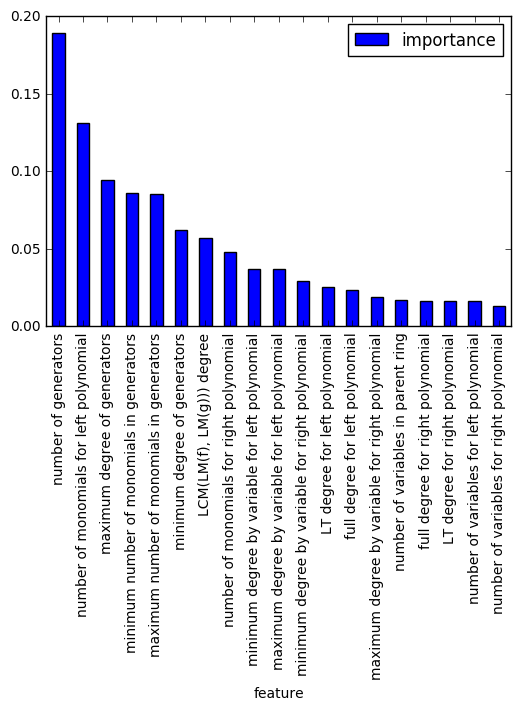

In [57]:
importances = GetFeatureImportancesForest(X, y_feat)

Для сравнения посмотрим на градацию важности признаков с помощью  SelectKBest.

                                                  importance
feature                                                     
number of generators                             2908.561566
maximum number of monomials in generators        1332.911095
number of monomials for left polynomial           778.870858
maximum degree of generators                      736.600768
number of monomials for right polynomial          677.279282
LCM(LM(f), LM(g))) degree                         536.986072
maximum degree by variable for left polynomial    436.444542
full degree for left polynomial                   425.697043
LT degree for left polynomial                     425.697043
LT degree for right polynomial                    229.312189
full degree for right polynomial                  229.312189
maximum degree by variable for right polynomial   174.792930
minimum degree by variable for left polynomial    110.725233
minimum degree by variable for right polynomial    47.047164
number of variables for 

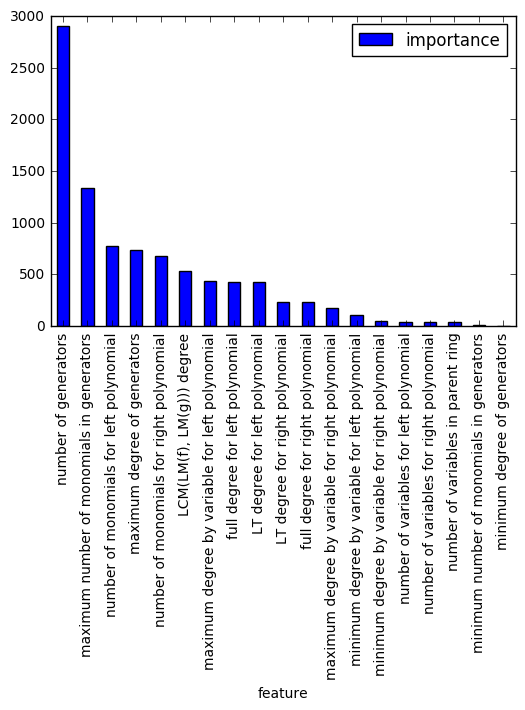

In [58]:
importances = GetFeatureImportancesKbest(X, y_feat)

Видно, что имеются довольно существенные различия, но самым важным в обоих случаях оказался признак "число порождающих текущего базиса" (number of generators).

Теперь обучим SVM и посмотрим на качество предсказаний по разным метрикам (разделение выборки на тестовую и обучающую, а также само обучение, происходят внутри TrainAndShowMetrics).

Classifier:

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)




accuracy = 0.892601431981 

             precision    recall  f1-score   support

 bad sPairs       0.94      0.83      0.88       592
good sPairs       0.86      0.95      0.90       665

avg / total       0.90      0.89      0.89      1257



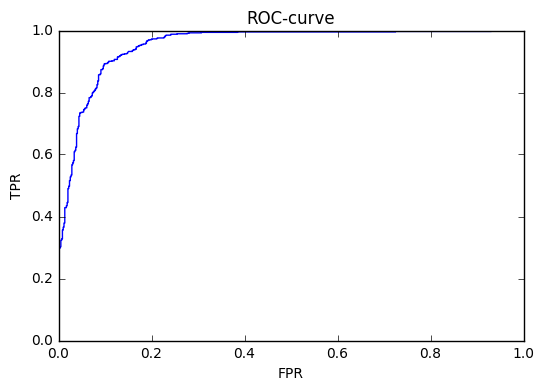

AUC-ROC: 0.954631934566


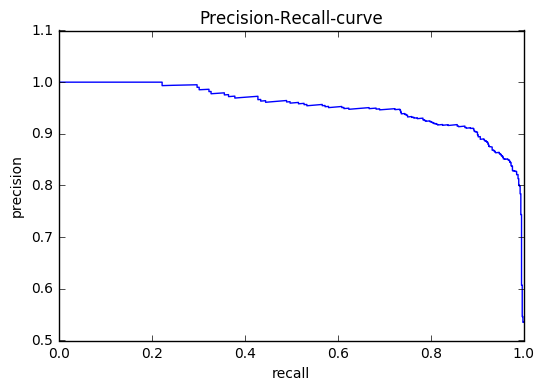

AUC-PR:  0.953969477072


In [41]:
clf = SVC(kernel = 'rbf', probability = True)

TrainAndShowMetrics(X, y_feat, 'bad sPairs', 'good sPairs', clf)

Проведём кросс-валидацию с пятью фолдами и посмотрим на качество в разных метриках.

In [40]:
clf = SVC(kernel = 'rbf', probability = True)
CrossValidation(clf, X, y_feat)

Classifier: 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)




accuracy results: [ 0.84815185  0.79120879  0.867       0.841       0.84284284]
best value:  0.867
mean value:  0.838040696441




recall results: [ 0.85201383  0.77939775  0.86023561  0.84187329  0.84611658]
best value:  0.860235607283
mean value:  0.835927409567


precision results: [ 0.84799479  0.79983316  0.87165479  0.8390954   0.8422039 ]
best value:  0.871654785556
mean value:  0.840156408231


roc_auc results: [ 0.9275293   0.8995449   0.93938897  0.89115906  0.91821009]
best value:  0.939388974518
mean value:  0.915166464809


Попробуем найти лучшие параметры для SVM с RBF-ядром с помощью поиска по сетке.

In [43]:
def GridSearch(clf, X_train, y_train, paramGrid):
    kf =  KFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(clf, param_grid=paramGrid, 
                        cv = kf, n_jobs=-1, 
                        scoring= 'roc_auc')
    grid.fit(X_train, y_train)
    bestParametersIdx = grid.cv_results_['mean_test_score'].argmax()
    print("Best cv result {} is reached for these parameters: \n{}".format(
           max(grid.cv_results_['mean_test_score']),
           grid.cv_results_['params'][bestParametersIdx]
    ))

In [44]:
grid = {'C' : [10**i for i in range(-2,3)], 'gamma' : [10**i for i in range(-2,2)]}

clf = SVC(kernel = 'rbf', probability = True)
GridSearch(clf, X, y_feat, grid)

Best cv result 0.958751827656 is reached for these parameters: 
{'C': 10, 'gamma': 1/10}


In [45]:
clf = SVC(kernel = 'rbf', probability = True, C=10, gamma=0.1)
CrossValidation(clf, X, y_feat)

Classifier: 

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.100000000000000,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)




accuracy results: [ 0.832  0.834  0.81   0.8    0.835]
best value:  0.834825870647
mean value:  0.822189383965




recall results: [ 0.833  0.833  0.807  0.803  0.841]
best value:  0.841111208946
mean value:  0.82330584846


precision results: [ 0.83   0.832  0.808  0.799  0.838]
best value:  0.838469603342
mean value:  0.821651626869


roc_auc results: [ 0.9    0.911  0.879  0.887  0.888]
best value:  0.910950640219
mean value:  0.893071539821


Почему-то качество стало хуже :(

Оставим параметры по умолчанию.

## Стратегия, основанная на машинном обучении

Будем выбирать S-пары, основываясь на предсказании классификатора. В функцию SelectionFunctionMachineLearning(pairs, basis, clf) передаём пары, текущий базис и классификатор. Сначала формируем признаки для каждой пары, потом формируем из них датасет и просим классификатор предсказать, нужна эта пара или нет. В соответствии с полученным вектором предсказаний берём пары (1 -- берём, 0 -- не берём). Если вдруг классификатор решил не брать ни одной пары, то проверяем, является ли текущий базис базисом Грёбнера. Если да, то останавливаемся. Если нет, то выбираем пары с помощью нормальной стратегии.

Есть ещё такая проблема: при создании датасета старым способом (то есть в виде pandas-таблицы) признаки перемешиваются. Если пытаться обучать алгоритм на полученных старым способом данных, а использовать на новых, то предсказания будут неверными из-за того, что порядок признаков другой. Поэтому для генерации датасета для алгорима (а не для первичного анализа данных) лучше использовать функцию CreateDataSetForNewStrategyNP(approximateNumOfObjects, maxVar, maxElem, maxDeg, minVar = 1, minElem = 2,  minDeg = 1), в которой порядок признаков фиксирован.

In [46]:
%time X_train, y_train = CreateDataSetForNewStrategyNP(approximateNumOfObjects=5000, maxVar=4, maxElem=4, maxDeg=4)

Current number of objects:  0
Current number of objects:  1
Current number of objects:  13
Current number of objects:  15
Current number of objects:  18
Current number of objects:  20
Current number of objects:  26
Current number of objects:  29
Current number of objects:  30
Current number of objects:  33
Current number of objects:  35
Current number of objects:  57
Current number of objects:  69
Current number of objects:  81
Current number of objects:  82
Current number of objects:  

87
Current number of objects:  88
Current number of objects:  91
Current number of objects:  97
Current number of objects:  100
Current number of objects:  102
Current number of objects:  106
Current number of objects:  130
Current number of objects:  133
Current number of objects:  134
Current number of objects:  137
Current number of objects:  140
Current number of objects:  142
Current number of objects:  146
Current number of objects:  147


Current number of objects:  149
Current number of objects:  152
Current number of objects:  174
Current number of objects:  178
Current number of objects:  183
Current number of objects:  185
Current number of objects:  188
Current number of objects:  194
Current number of objects:  218
Current number of objects:  219
Current number of objects:  221
Current number of objects:  223
Current number of objects:  226
Current number of objects:  234
Current number of objects:  236
Current number of objects:  238
Current number of objects:  241
Current number of objects:  244
Current number of objects:  247


Current number of objects:  262
Current number of objects:  265
Current number of objects:  284
Current number of objects:  286
Current number of objects:  290
Current number of objects:  291
Current number of objects:  293
Current number of objects:  331
Current number of objects:  333
Current number of objects:  335


Current number of objects:  353
Current number of objects:  356
Current number of objects:  358
Current number of objects:  386
Current number of objects:  389
Current number of objects:  392
Current number of objects:  399


Current number of objects:  448
Current number of objects:  454
Current number of objects:  455
Current number of objects:  461
Current number of objects:  463
Current number of objects:  465
Current number of objects:  468
Current number of objects:  471
Current number of objects:  486
Current number of objects:  489
Current number of objects:  492
Current number of objects:  495
Current number of objects:  522
Current number of objects:  525
Current number of objects:  539
Current number of objects:  540
Current number of objects: 

 541
Current number of objects:  543
Current number of objects:  546
Current number of objects:  548
Current number of objects:  563
Current number of objects:  565
Current number of objects:  566
Current number of objects:  575
Current number of objects:  590
Current number of objects:  592
Current number of objects:  597
Current number of objects:  603
Current number of objects:  604


Current number of objects:  620
Current number of objects:  622
Current number of objects:  627
Current number of objects:  630
Current number of objects:  631
Current number of objects:  633
Current number of objects:  635
Current number of objects:  637
Current number of objects:  643
Current number of objects:  646
Current number of objects:  648
Current number of objects:  661
Current number of objects:  665
Current number of objects:  667
Current number of objects:  668
Current number of objects:  671
Current number of objects:  672
Current number of objects:  678
Current number of objects:  679
Current number of objects:  680
Current number of objects:  681
Current number of objects:  682
Current number of objects: 

 690
Current number of objects:  693
Current number of objects:  695
Current number of objects:  699
Current number of objects:  703
Current number of objects:  715
Current number of objects:  721
Current number of objects:  724
Current number of objects:  746
Current number of objects:  752


Current number of objects:  840
Current number of objects:  846
Current number of objects:  847
Current number of objects:  849
Current number of objects:  853
Current number of objects:  868
Current number of objects:  870
Current number of objects:  876
Current number of objects:  878


Current number of objects:  920
Current number of objects:  922
Current number of objects:  924
Current number of objects:  928
Current number of objects:  958
Current number of objects:  959
Current number of objects:  960
Current number of objects:  961
Current number of objects:  963
Current number of objects:  969
Current number of objects:  971


Current number of objects:  1020
Current number of objects:  1022
Current number of objects:  1024
Current number of objects:  1033
Current number of objects:  1034
Current number of objects:  1054
Current number of objects:  1060
Current number of objects:  1069


Current number of objects:  1126
Current number of objects:  1127


Current number of objects:  1160
Current number of objects:  1162
Current number of objects:  1168
Current number of objects:  1188
Current number of objects:  1189
Current number of objects:  1190
Current number of objects:  1214
Current number of objects:  1215
Current number of objects:  1217
Current number of objects:  1220
Current number of objects:  1229
Current number of objects:  1232


Current number of objects:  1241
Current number of objects:  1245
Current number of objects:  1247
Current number of objects:  1250
Current number of objects:  1253
Current number of objects:  1262


Current number of objects:  1303
Current number of objects:  1306
Current number of objects:  1311
Current number of objects:  1326
Current number of objects:  1332
Current number of objects:  1334
Current number of objects:  1337
Current number of objects:  1338
Current number of objects:  1339
Current number of objects:  1345
Current number of objects:  1348


Current number of objects:  1408
Current number of objects:  1411
Current number of objects:  1424


Current number of objects:  1550
Current number of objects:  1559
Current number of objects:  1561
Current number of objects:  1563
Current number of objects:  1569
Current number of objects:  1575
Current number of objects:  1576
Current number of objects:  1578
Current number of objects:  1579


Current number of objects:  1638
Current number of objects:  1640
Current number of objects:  1644
Current number of objects:  1688
Current number of objects:  1693
Current number of objects:  1696
Current number of objects:  1698


Current number of objects:  1716
Current number of objects:  1740
Current number of objects:  1746
Current number of objects:  1758
Current number of objects:  1760
Current number of objects:  1762
Current number of objects:  1765
Current number of objects:  1766
Current number of objects:  1767
Current number of objects:  1772
Current number of objects:  1775
Current number of objects:  1778
Current number of objects:  1781


Current number of objects:  1787
Current number of objects:  1793
Current number of objects:  1813
Current number of objects:  1818


Current number of objects:  1986
Current number of objects:  1987
Current number of objects:  1989
Current number of objects:  1991
Current number of objects:  1992
Current number of objects:  1995
Current number of objects:  2002
Current number of objects:  2005
Current number of objects:  2008
Current number of objects:  2023
Current number of objects:  2056


Current number of objects:  2057
Current number of objects:  2059
Current number of objects:  2060
Current number of objects:  2063
Current number of objects:  2069
Current number of objects:  2071
Current number of objects:  2072
Current number of objects:  2074


Current number of objects:  2083
Current number of objects:  2084
Current number of objects:  2087
Current number of objects:  2090
Current number of objects:  2109
Current number of objects:  2110
Current number of objects:  2113


Current number of objects:  2117
Current number of objects:  2120
Current number of objects:  2121
Current number of objects:  2123
Current number of objects:  2134
Current number of objects:  2135
Current number of objects:  2137
Current number of objects:  2140


Current number of objects:  2143
Current number of objects:  2146


Current number of objects:  2192


Current number of objects:  2277
Current number of objects:  2279
Current number of objects:  2282
Current number of objects:  2288
Current number of objects:  2293
Current number of objects:  2295


Current number of objects:  2320
Current number of objects:  2326
Current number of objects:  2327
Current number of objects:  2328
Current number of objects:  2329
Current number of objects:  2331
Current number of objects:  2335
Current number of objects:  2356


Current number of objects:  2407
Current number of objects:  2409
Current number of objects:  2412
Current number of objects:  2417
Current number of objects:  2420
Current number of objects:  2423
Current number of objects:  2425
Current number of objects:  2426
Current number of objects:  2428
Current number of objects:  2432
Current number of objects:  2435
Current number of objects:  2439


Current number of objects:  2461
Current number of objects:  2463
Current number of objects:  2466
Current number of objects:  2467
Current number of objects:  2475
Current number of objects:  2477
Current number of objects:  2482


Current number of objects:  2510
Current number of objects:  2514
Current number of objects:  2519
Current number of objects:  2521
Current number of objects:  2523
Current number of objects:  2529
Current number of objects:  2542
Current number of objects:  2543
Current number of objects:  2545
Current number of objects:  2557


Current number of objects:  2569
Current number of objects:  2570
Current number of objects:  2573
Current number of objects:  2577
Current number of objects:  2581
Current number of objects:  2586
Current number of objects:  2590
Current number of objects:  2591
Current number of objects:  2603
Current number of objects:  2623
Current number of objects:  2625
Current number of objects:  2627
Current number of objects:  2637
Current number of objects:  

2664
Current number of objects:  2665
Current number of objects:  2667


Current number of objects:  2846
Current number of objects:  2858
Current number of objects:  2860
Current number of objects:  2861
Current number of objects:  2888
Current number of objects:  2894
Current number of objects:  2909
Current number of objects:  2910
Current number of objects:  2940
Current number of objects:  2941
Current number of objects:  2943


Current number of objects:  2988
Current number of objects:  3023
Current number of objects:  3025
Current number of objects:  3029
Current number of objects:  3032
Current number of objects:  3038


Current number of objects:  3062
Current number of objects:  3070
Current number of objects:  3087
Current number of objects:  3122
Current number of objects:  

3127
Current number of objects:  3129
Current number of objects:  3133
Current number of objects:  3149
Current number of objects:  3151
Current number of objects:  3154
Current number of objects:  3156
Current number of objects:  3158
Current number of objects:  3159
Current number of objects:  3160


Current number of objects:  3192
Current number of objects:  3195
Current number of objects:  3200
Current number of objects:  3235
Current number of objects:  3250


Current number of objects:  3255
Current number of objects:  3259
Current number of objects:  3268
Current number of objects:  3269
Current number of objects:  3275
Current number of objects:  3277
Current number of objects:  3279
Current number of objects:  3282
Current number of objects:  3285
Current number of objects:  3320
Current number of objects:  3321


Current number of objects:  3376
Current number of objects:  3380
Current number of objects:  3384
Current number of objects:  3385
Current number of objects:  3389
Current number of objects:  3391
Current number of objects:  3394
Current number of objects:  3406
Current number of objects:  3408
Current number of objects:  3409
Current number of objects:  3449


Current number of objects:  3544
Current number of objects:  3554
Current number of objects:  3556
Current number of objects:  3592
Current number of objects:  3595
Current number of objects:  3617
Current number of objects:  3620
Current number of objects:  3622
Current number of objects:  3638


Current number of objects:  3639
Current number of objects:  3663
Current number of objects:  3665
Current number of objects:  3667
Current number of objects:  3674
Current number of objects:  3675
Current number of objects:  3678
Current number of objects:  3690
Current number of objects:  3696
Current number of objects:  3701
Current number of objects:  3704
Current number of objects:  3710
Current number of objects:  3715
Current number of objects:  3717
Current number of objects:  3721
Current number of objects:  

3725
Current number of objects:  3728
Current number of objects:  3729
Current number of objects:  3731
Current number of objects:  3734


Current number of objects:  3780
Current number of objects:  3791
Current number of objects:  3795
Current number of objects:  3803
Current number of objects:  3805
Current number of objects:  3818
Current number of objects:  3821
Current number of objects:  3823
Current number of objects:  3825


Current number of objects:  3866
Current number of objects:  3867


Current number of objects:  3941
Current number of objects:  3946
Current number of objects:  3948
Current number of objects:  3950
Current number of objects:  3961
Current number of objects:  3964
Current number of objects:  3967
Current number of objects:  3968
Current number of objects:  3987
Current number of objects:  3996
Current number of objects:  3998
Current number of objects:  4002
Current number of objects:  4008
Current number of objects:  4011
Current number of objects:  

4016
Current number of objects:  4019
Current number of objects:  4022
Current number of objects:  4027
Current number of objects:  4059
Current number of objects:  4074
Current number of objects:  4086
Current number of objects:  

4092
Current number of objects:  4093
Current number of objects:  4094
Current number of objects:  4098
Current number of objects:  4102
Current number of objects:  4104
Current number of objects:  4106
Current number of objects:  4112
Current number of objects:  4118
Current number of objects:  4121
Current number of objects:  4123


Current number of objects:  4172
Current number of objects:  4207
Current number of objects:  4209
Current number of objects:  4211
Current number of objects:  4243
Current number of objects:  4245
Current number of objects:  4248
Current number of objects:  4253
Current number of objects:  4265
Current number of objects:  4267


Current number of objects:  4282
Current number of objects:  4298
Current number of objects:  4301
Current number of objects:  4306
Current number of objects:  4320
Current number of objects:  4331


Current number of objects:  4332
Current number of objects:  4334
Current number of objects:  4337
Current number of objects:  4338
Current number of objects:  4339
Current number of objects:  4343
Current number of objects:  4345


Current number of objects:  4376
Current number of objects:  4381
Current number of objects:  4384
Current number of objects:  4389
Current number of objects:  4391
Current number of objects:  4393
Current number of objects:  4407
Current number of objects:  4408
Current number of objects:  4410
Current number of objects:  4412
Current number of objects:  4413
Current number of objects:  4414
Current number of objects:  4415


Current number of objects:  4417
Current number of objects:  4419
Current number of objects:  4421
Current number of objects:  4423
Current number of objects:  4428
Current number of objects:  4430
Current number of objects:  4450
Current number of objects:  4452
Current number of objects:  4453
Current number of objects:  4461
Current number of objects:  4464
Current number of objects:  4470
Current number of objects:  4476
Current number of objects:  4478
Current number of objects:  

4481
Current number of objects:  4487
Current number of objects:  4490
Current number of objects:  4501
Current number of objects:  4502
Current number of objects:  4503
Current number of objects:  4522
Current number of objects:  4523
Current number of objects:  4529
Current number of objects:  4533
Current number of objects:  4535
Current number of objects:  4536
Current number of objects:  4539
Current number of objects:  4540
Current number of objects:  4541
Current number of objects:  4542


Current number of objects:  4549
Current number of objects:  4553
Current number of objects:  4559
Current number of objects:  4566
Current number of objects:  4572
Current number of objects:  4583
Current number of objects:  4585
Current number of objects:  4589
Current number of objects:  4591
Current number of objects:  4595
Current number of objects: 

 4597
Current number of objects:  4600
Current number of objects:  4601
Current number of objects:  4605
Current number of objects:  4609
Current number of objects:  4615
Current number of objects:  4621
Current number of objects:  4622
Current number of objects:  4635
Current number of objects:  4638
Current number of objects:  4640
Current number of objects:  4643
Current number of objects:  4644


In [47]:
X_train.shape

(5009, 19)

Classifier:

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)




accuracy = 0.902478017586 

             precision    recall  f1-score   support

 bad sPairs       0.92      0.84      0.88       514
good sPairs       0.89      0.95      0.92       737

avg / total       0.90      0.90      0.90      1251



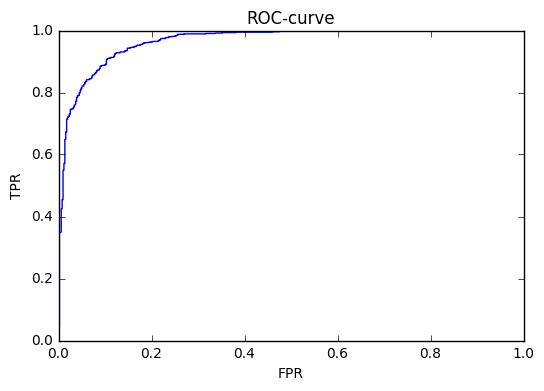

AUC-ROC: 0.965670849854


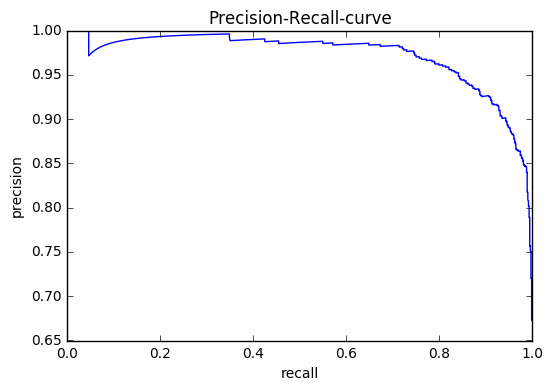

AUC-PR:  0.972043304585


In [55]:
clf = SVC(kernel = 'rbf', probability = True)
clf.fit(X_train, y_train)

TrainAndShowMetrics(X_train, y_train, 'bad sPairs', 'good sPairs', clf)

Если датасет вышел хорошим (то есть на нём хорошо обучился классификатор), сохраняем его.

In [48]:
output1 = open('X_train_new_scaler.pkl', 'wb')
pickle.dump(X_train, output1, 2)
output1.close()

output2 = open('y_train_new_scaler.pkl', 'wb')
pickle.dump(y_train, output2, 2)
output2.close()

Можно воспользоваться старым датасетом.

In [49]:
input1 = open('X_train_444_19.pkl', 'rb')
X_train = pickle.load(input1)
input1.close()

input2 = open('y_train_444_19.pkl', 'rb')
y_train = pickle.load(input2)
input2.close()

In [99]:
# dataset for new features

input1 = open('X_train_new_scaler.pkl', 'rb')
X_train = pickle.load(input1)
input1.close()

input2 = open('y_train_new_scaler.pkl', 'rb')
y_train = pickle.load(input2)
input2.close()

In [50]:
X_train.shape

(5001, 19)

## Эксперименты: сравнение по максимальным размерам редуцируемых матриц и времени работы

### Сравнение стратегий ML и normal

In [56]:
input1 = open('X_train_444_19.pkl', 'rb')
X_train = pickle.load(input1)
input1.close()

input2 = open('y_train_444_19.pkl', 'rb')
y_train = pickle.load(input2)
input2.close()

In [57]:
clf = SVC(kernel = 'rbf', probability = True)
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

На небольших системах ML не даёт выигрыша.

In [58]:
%time matrices, times =  LaunchF4_time_and_matrix_sizes(20, maxVar=4, maxElem=4, maxDeg=4 'normal', 'ML', clf)

Object No:  0
Object No:  1


Object No:  2
Object No:  3
Object No:  4
Object No:  5
Object No:  6
Object No:  7


Object No:  8
Object No:  9
Object No:  10
Object No:  11
Object No:  12
Object No:  13
Object No:  14


Object No:  15
Object No:  16
Object No:  17
Object No:  18
Object No:  19



times when normal is better:  7
times when ML is better:  13

system where normal worked most slowly:  [-x1^2 + 1/2*x1*x2 + 2*x2^2 + 1/8, -7*x0^2*x1 - 1/10*x0*x1^2 + x1^2*x2 + 5/3*x0*x2 - 2/3*x1*x2, x0^2*x1 - 6/5*x0*x1 - x0*x2 + 2*x1*x2 - x0]

system where ML worked most slowly:  [-x1^2 + 1/2*x1*x2 + 2*x2^2 + 1/8, -7*x0^2*x1 - 1/10*x0*x1^2 + x1^2*x2 + 5/3*x0*x2 - 2/3*x1*x2, x0^2*x1 - 6/5*x0*x1 - x0*x2 + 2*x1*x2 - x0]


Mean matrix size:
normal :  320.4 ,  ML :  320.4
Max matrix size:
normal :  3410 ,  ML :  3795
Min matrix size:
normal :  6 ,  ML :  6


Mean time:
normal :  0.0280245304108 ,  ML :  0.0345502018929
Max time:
normal :  0.218904018402 ,  ML :  0.386710166931
Min time:
normal :  0.00358104705811 ,  ML :  0.00240516662598
CPU times: user 880 ms, sys: 85.3 ms, total: 966 ms
Wall time: 1.31 s


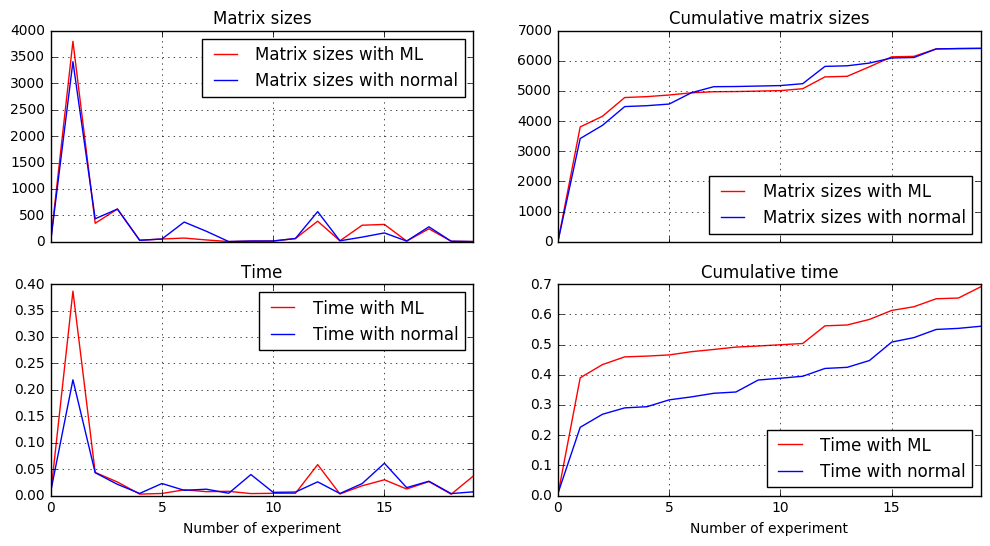

In [59]:
DrawFrame(matrices, times)

In [60]:
%time matrices, times =  LaunchF4_time_and_matrix_sizes(100, 4, 5, 5, 'normal', 'ML', clf)

Object No:  0


Object No:  10


Object No:  20


Object No:  30


Object No:  40


Object No:  50


Object No:  60


Object No:  70


Object No:  80


Object No:  90



times when normal is better:  54
times when ML is better:  46

system where normal worked most slowly:  [-x0^2*x1^2 - x0^3 - 1/2*x1^2 + 1, 5*x0^2 - x1^2 - 7/2*x0*x2 - x2^2 + x1, 2*x0^2*x1^2 - 2*x0*x1*x2^2 - 5/2*x0*x2^3 + 1/2*x1*x2^3 - 16/5*x2^2]

system where ML worked most slowly:  [-x0^2*x1 + 33*x0*x1^2 + 1/4*x0*x2 - 15*x0 + 1/2*x2, 1/2*x0^3*x1 - 1/2*x0*x1^2*x2 - x0*x1*x2^2 + 2*x0*x2, -1/5*x0*x1^2 + 2*x0^2*x2 + 3*x0*x1*x2 - 4*x0, -1/7*x1^2*x2^2 + 1/2*x1^2*x2 + 1/2*x0*x1 + 20*x0*x2]


Mean matrix size:
normal :  976.71 ,  ML :  1123.52
Max matrix size:
normal :  20724 ,  ML :  16920
Min matrix size:
normal :  8 ,  ML :  6


Mean time:
normal :  0.0592291212082 ,  ML :  0.0573582434654
Max time:
normal :  0.733137130737 ,  ML :  0.78785610199
Min time:
normal :  0.00228309631348 ,  ML :  0.00178599357605
CPU times: user 10.6 s, sys: 271 ms, total: 10.9 s
Wall time: 11.8 s


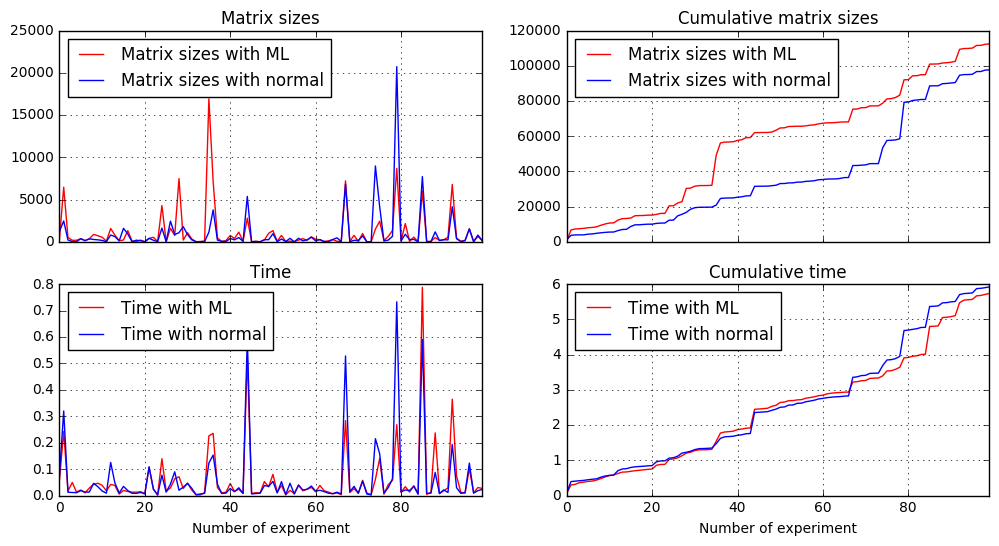

In [61]:
DrawFrame(matrices, times)

Однако на достаточно больших системах есть существенное ускорение по сравнению с normal.

In [63]:
%time matrices, times =  LaunchF4_time_and_matrix_sizes(100, 5, 5, 5, 'normal', 'ML', clf)

Object No:  0


Object No:  10


Object No:  20


Object No:  30


Object No:  40


Object No:  50


Object No:  60


Object No:  70


Object No:  80


Object No:  90



times when normal is better:  39
times when ML is better:  61

system where normal worked most slowly:  [3/4*x3^4 - 2*x0^2*x1 + x1*x3, -x0 - 1/5*x1 + 1/589*x2 - x3 - 5, 2*x0^2*x1*x2 - 3*x0*x1^2*x3 - 1/6*x0*x2^2, x1^2*x2^2 - 3/2*x0^2*x2*x3 + x2^2*x3 - 1/2*x0*x1]

system where ML worked most slowly:  [3/4*x3^4 - 2*x0^2*x1 + x1*x3, -x0 - 1/5*x1 + 1/589*x2 - x3 - 5, 2*x0^2*x1*x2 - 3*x0*x1^2*x3 - 1/6*x0*x2^2, x1^2*x2^2 - 3/2*x0^2*x2*x3 + x2^2*x3 - 1/2*x0*x1]


Mean matrix size:
normal :  41172.46 ,  ML :  6693.98
Max matrix size:
normal :  1736395 ,  ML :  214182
Min matrix size:
normal :  6 ,  ML :  6


Mean time:
normal :  3.07155680656 ,  ML :  0.273883140087
Max time:
normal :  210.009939909 ,  ML :  12.9117081165
Min time:
normal :  0.00286507606506 ,  ML :  0.00224995613098
CPU times: user 5min 18s, sys: 2.35 s, total: 5min 20s
Wall time: 5min 34s


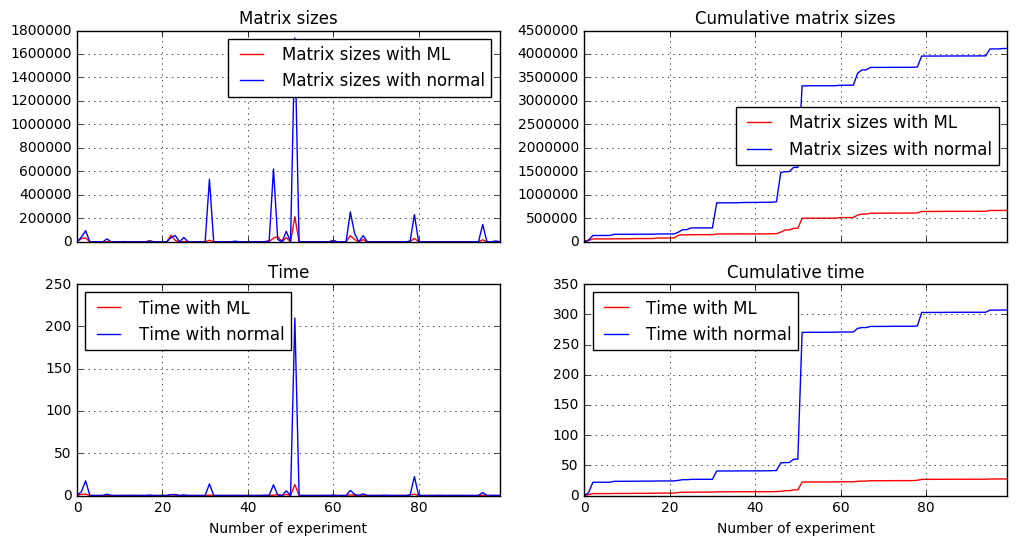

In [64]:
DrawFrame(matrices, times)

### Эксперимент со сложными системами

Во всех прошлых экспериментах системы на каждой итерации бывали разной степени сложности, в том числе совсем лёгкие. Хочется попробовать запустить F4 с машинным обучением на достаточно больших системах.

In [73]:
def GetBigRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg, minVar = 4, minElem = 4,  minDeg = 4):
    nVar = np.random.randint(minVar, maxVar)
    nElem = np.random.randint(minElem, maxElem)

    R = PolynomialRing(QQ, 'x', nVar)
    generators = []

    if nVar + nElem % 2 == 1:
        R = (R.gens()[0] + 1).homogenize().parent()     # if we apply .homognize() to a homogeneous polynomial it's parent ring won't change
                                                        # but we want to have a unique parent for all generators
    for i in range(nElem):
        deg = np.random.randint(minDeg, maxDeg)
        randomPol = R.random_element(degree = deg)

        while randomPol.degree() < 2:
            randomPol = R.random_element(degree = deg)

        if nVar + nElem % 2 == 1:    # just a random criteria for a homogeneous ideal to appear
            generators.append(R(randomPol.homogenize()))
        else:
            generators.append(randomPol)
    return generators

In [74]:
def LaunchF4_time_and_matrix_sizes_big(n, maxVar, maxElem, maxDeg, stratOne, stratTwo, clf, new_features = False):
    times = [[], []]
    matrixSizes = [[], []]
    maxTimeFirst, maxTimeSecond = 0, 0
    maxGensFirstStrat, maxGensSecondStrat, gens = [], [], []
    timesWhenFirstStratBetter = 0
    timesWhenSecondStratBetter = 0

    for i in range(n):
        Print(n, i)
        generators = GetBigRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg)
        while 0 in generators or is_groebner_basis(generators):
            generators = GetBigRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg)
        gens.append(generators)
        print('generators = ', generators)

        t2 = time()
        basis, numOfStepsML = F4_ML(generators, stratTwo, clf, new_features)
        t2 = time() - t2
        matrixSizes[1].append(numOfStepsML)
        times[1].append(t2)
        print("ML TIME: ", t2)

        t1 = time()
        basis, numOfStepsNormal = F4_ML(generators, stratOne, clf, new_features)
        t1 = time() - t1
        matrixSizes[0].append(numOfStepsNormal)
        times[0].append(t1)
        print("NORMAL TIME: ", t1)

        if t1 > t2:
            timesWhenSecondStratBetter += 1
        else:
            timesWhenFirstStratBetter += 1

        if t1 > maxTimeFirst:
            maxTimeFirst = t1
            maxGensFirstStrat = generators

        if t2 > maxTimeSecond:
            maxTimeSecond = t2
            maxGensSecondStrat = generators

    print "\ntimes when {} is better: ".format(stratOne), timesWhenFirstStratBetter
    print "times when {} is better: ".format(stratTwo), timesWhenSecondStratBetter
    print "\nsystem where {} worked most slowly: ".format(stratOne), maxGensFirstStrat
    print "\nsystem where {} worked most slowly: ".format(stratTwo), maxGensSecondStrat

    PrintResultsForStrategies(matrixSizes, stratOne, stratTwo, "matrix size")
    PrintResultsForStrategies(times, stratOne, stratTwo, "time")

    indices = [i for i in range(n)]
    d1 = {
        'Matrix sizes with {}'.format(stratOne) : pd.Series([t for t in matrixSizes[0]], index = indices),
        'Matrix sizes with {}'.format(stratTwo): pd.Series([t for t in matrixSizes[1]], index = indices),
    }

    d2 = {
        'Time with {}'.format(stratOne) : pd.Series([t for t in times[0]], index = indices),
        'Time with {}'.format(stratTwo): pd.Series([t for t in times[1]], index = indices),
    }
    return pd.DataFrame(d1), pd.DataFrame(d2), gens

In [47]:
clf = SVC(kernel = 'rbf', probability = True, C=100, gamma=0.01)
clf.fit(X_train, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0100000000000000,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Запустим эксперимент на пяти больших системах.

In [33]:
set_verbose(1)
%time matrices, times, generators =  LaunchF4_time_and_matrix_sizes_big(5, 5, 5, 5, 'normal', 'ML', clf)

Object No:  0
('generators = ', [-x1^4 - x1^2*x3^2 + x1^3 - 1/3*x1*x2*x3, x0^3*x3 - 2/11*x0^2*x2*x3 + 2*x1^2*x3 - 4/11*x1*x3^2 - x1^2, 1/2*x1*x2^3 - 1/3*x2^3, 5*x0^2*x2^2 - 2*x2^4 + 2*x0*x3^2])
// ** right side is not a datum, assignment ignored
// ** in line >>def sage304=option(sage303);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage306=option(sage305);<<
verbose 1 (multimod echelon) Multimodular echelon algorithm on 8 x 15 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage309=option(sage308);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage311=option(sage310);<<
verbose 1 (multimod echelon) Multimodular echelon algorithm on 30 x 56 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage314=option(sage313);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage316=option(sage315);<<
verbose 1 (multimod echelon) Multimodular echelon algorithm on 9 x 19 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage319=option(sage318);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage321=option(sage320);<<
verbose 1 (multimod echelon) Multimodular echelon algorithm on 53 x 81 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage324=option(sage323);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage326=option(sage325);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 53 x 86 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 

// ** right side is not a datum, assignment ignored
// ** in line >>def sage329=option(sage328);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage331=option(sage330);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 9 x 11 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage334=option(sage333);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage336=option(sage335);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 107 x 138 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage339=option(sage338);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage341=option(sage340);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 59 x 93 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage344=option(sage343);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage346=option(sage345);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 41 x 77 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage349=option(sage348);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage351=option(sage350);<<
verbose 1 (multimod echelon) Multimodular echelon algorithm on 61 x 91 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage354=option(sage353);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage356=option(sage355);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 38 x 64 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage359=option(sage358);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage361=option(sage360);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 343 x 268 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage364=option(sage363);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage366=option(sage365);<<
verbose 1 (multimod echelon) Multimodular echelon algorithm on 53 x 90 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage369=option(sage368);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage371=option(sage370);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 34 x 69 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage374=option(sage373);<<
// ** right side is not a datum, assignment ignored


// ** in line >>def sage376=option(sage375);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 202 x 216 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 

verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage379=option(sage378);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage381=option(sage380);<<
verbose 1 (multimod echelon) Multimodular echelon algorithm on 38 x 76 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage384=option(sage383);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage386=option(sage385);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 19 x 31 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage389=option(sage388);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage391=option(sage390);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 121 x 152 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage394=option(sage393);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage396=option(sage395);<<


('ML TIME: ', 5.132548093795776)
verbose 1 (multimod echelon) Multimodular echelon algorithm on 8 x 15 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 30 x 56 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 9 x 19 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 53 x 81 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 53 x 86 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 

verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 9 x 11 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 107 x 138 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 

verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 59 x 93 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 41 x 77 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 61 x 91 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 38 x 64 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 343 x 268 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 53 x 90 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


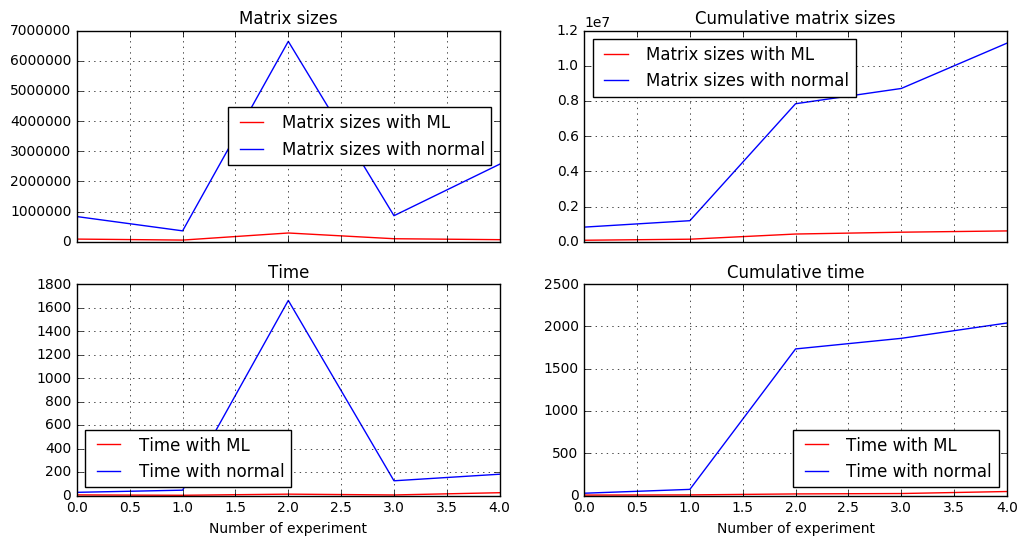

In [34]:
DrawFrame(matrices, times)

Посмтрим на вышедшие датасеты времени и размеров матриц.

In [35]:
times

,Time with ML,Time with normal
0,5.132548,26.962531
1,1.981919,45.377418
2,11.498366,1661.201881
3,4.661313,125.267445
4,23.795288,181.318144


In [48]:
matrices

,Matrix sizes with ML,Matrix sizes with normal
0,91924,837209
1,59110,364620
2,293748,6640426
3,103934,866232
4,72540,2572440


ML везде отработала намного быстрее. Выведем эти системы:

In [47]:
for gens in generators:
    print gens, '\n'

[-x1^4 - x1^2*x3^2 + x1^3 - 1/3*x1*x2*x3, x0^3*x3 - 2/11*x0^2*x2*x3 + 2*x1^2*x3 - 4/11*x1*x3^2 - x1^2, 1/2*x1*x2^3 - 1/3*x2^3, 5*x0^2*x2^2 - 2*x2^4 + 2*x0*x3^2] 

[x0^3*x3 + 1/2*x0^2*x1*x3 + 4*x2^2*x3 - 1/2*x3^3, -x1^3*x2 + x0^2*x2*x3 - 5*x1^2*x2, 17/12*x0^2*x1^2 + 2*x0^3*x2 - 4*x1^3*x2 - 14*x1^2*x3^2 + 3*x0^2*x1, 1/8*x0*x2 + 3/2*x3^2] 

[-2*x0^3*x2 - 1/20*x0*x2*x3^2 + 1/3*x2^2*x3^2 + 1/8*x1*x3^3 - 2/7*x0^2*x1, -137/4*x0*x1*x2*x3 + 2*x1*x2^2 - 11*x2*x3 + 2/5*x1, 4*x0^3*x2 - 1/3*x0*x1*x2*x3 - 7/3*x1*x2*x3^2 + x1, -x0*x3^3 + 3*x1^3 - x2^3 + 3*x1^2] 

[x0*x1 + x0*x2 + 13*x3^2, -7*x0^3*x1 - 1/11*x1^3*x3 - 1/7*x1^3 - 3*x1^2*x3 + 3*x2^2, 7*x0*x1*x2*x3 - 2*x3^4 - x0*x1*x2 + 11*x1*x3^2 + 2/55*x1*x2, -2/67*x1^4 + 2*x0*x2 - x2^2 - 3*x1*x3] 

[3*x1^4 - x0*x1^2*x3 + 3*x0^2*x2*x3 + x2*x3^3 + x1^2, -1/5*x1^3*x3 - x0^2*x2*x3 + 4*x0*x3^2 - x3^2, -x1^2*x2^2 + 2*x0^2*x1*x3 + 1/8*x0*x1*x2 + 4*x2 + 7*x3, 1/9*x0^2*x1*x2 + x1^2*x3 - 1/16*x0*x2] 



Запустим обе стратегии на одной из них.

In [75]:
R.<x0, x1, x2, x3> = QQ[]
%time basis = F4_ML([x0^3*x3 + 1/2*x0^2*x1*x3 + 4*x2^2*x3 - 1/2*x3^3, -x1^3*x2 + x0^2*x2*x3 - 5*x1^2*x2, 17/12*x0^2*x1^2 + 2*x0^3*x2 - 4*x1^3*x2 - 14*x1^2*x3^2 + 3*x0^2*x1, 1/8*x0*x2 + 3/2*x3^2], 'normal', clf, new_features=False)

CPU times: user 43.8 s, sys: 189 ms, total: 44 s
Wall time: 46.9 s


In [67]:
R.ideal(basis[0]).basis_is_groebner()

True

In [76]:
%time basis = F4_ML([x0^3*x3 + 1/2*x0^2*x1*x3 + 4*x2^2*x3 - 1/2*x3^3, -x1^3*x2 + x0^2*x2*x3 - 5*x1^2*x2, 17/12*x0^2*x1^2 + 2*x0^3*x2 - 4*x1^3*x2 - 14*x1^2*x3^2 + 3*x0^2*x1, 1/8*x0*x2 + 3/2*x3^2], 'ML', clf, new_features=False)

CPU times: user 1.31 s, sys: 20 ms, total: 1.33 s
Wall time: 1.4 s


In [77]:
R.ideal(basis[0]).basis_is_groebner()

True

### Другие признаки

Была попытка сделать другой набор признаков.

1. Максимальная степень элементов в текущем базисе.
2. Число мономов в левом полиноме.
3. Минимальное число мономов у полиномов в текущем базисе.
4. Отношение наибольшего и наименьшего коэффициентов в левом полиноме.
5. Пропорция топ-редуцируемых мономов в левом полиноме.
6. Сумма коэффициентов для левого полинома.
7. Минимальная степень по переменной для левого полинома.
8. Минимальная степень элементов в текущем базисе.
9. Число элементов в базисе.
10. Максимальное число мономов у полиномов в текущем базисе.
11. Максимальная степень по переменной для левого полинома.
12. Степень НОК для S-пары.
13. Степень старшего многочлена для левого полинома.
14. Полная степень левого полинома.
15. Число мономов в S-полиноме.
16. Минимальная степень по переменной для правого полинома.
17. Сумма коэффициентов для правого полинома.
18. Число мономов в правом полиноме.
19. Число переменных в левом полиноме.

Сначала к старым признакам были добавлены новые (про коэффициенты и признаки S-полинома), а затем признаки отбирались на основе градации важности по версии случайного леса. Также убирались сильно коррелированные признаки.

In [78]:
input1 = open('X_train_new_scaler.pkl', 'rb')
X_train = pickle.load(input1)
input1.close()

input2 = open('y_train_new_scaler.pkl', 'rb')
y_train = pickle.load(input2)
input2.close()

In [79]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

clf = SVC(kernel = 'rbf', probability = True)
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [67]:
set_verbose(0)
%time matrices, times =  LaunchF4_time_and_matrix_sizes(20, 4, 4, 4, 'normal', 'ML', clf, new_features = True)

Object No:  0


Object No:  1
Object No:  2
Object No:  3
Object No:  4
Object No:  5
Object No:  6


Object No:  7
Object No:  8
Object No:  9
Object No:  10
Object No:  11
Object No:  12
Object No:  13
Object No:  14


Object No:  15
Object No:  16
Object No:  17
Object No:  18
Object No: 

 19

times when normal is better:  18
times when ML is better:  2

system where normal worked most slowly:  [-x1^2 - x1*x2 - 1/4*x2^2 - 2*x0 + x2, x0^2*x2 + x0*x1*x2 - 12*x1^2*x2 - 2*x2^3, x1^2*x2 + 1/5*x0*x1 + 1/2*x1^2 + 5*x0*x2 - 1/2*x1*x2]

system where ML worked most slowly:  [-2/19*x^3 - 4*x*h^2 + 9*h^3, -4*x*h^2 - h^3]


Mean matrix size:
normal :  251.15 ,  ML :  104.45
Max matrix size:
normal :  2530 ,  ML :  1302
Min matrix size:
normal :  6 ,  ML :  6


Mean time:
normal :  0.0162530899048 ,  ML :  0.0383019924164
Max time:
normal :  0.0877139568329 ,  ML :  0.297902822495
Min time:
normal :  0.00341510772705 ,  ML :  0.00709891319275
CPU times: user 959 ms, sys: 60.5 ms, total: 1.02 s
Wall time: 1.14 s


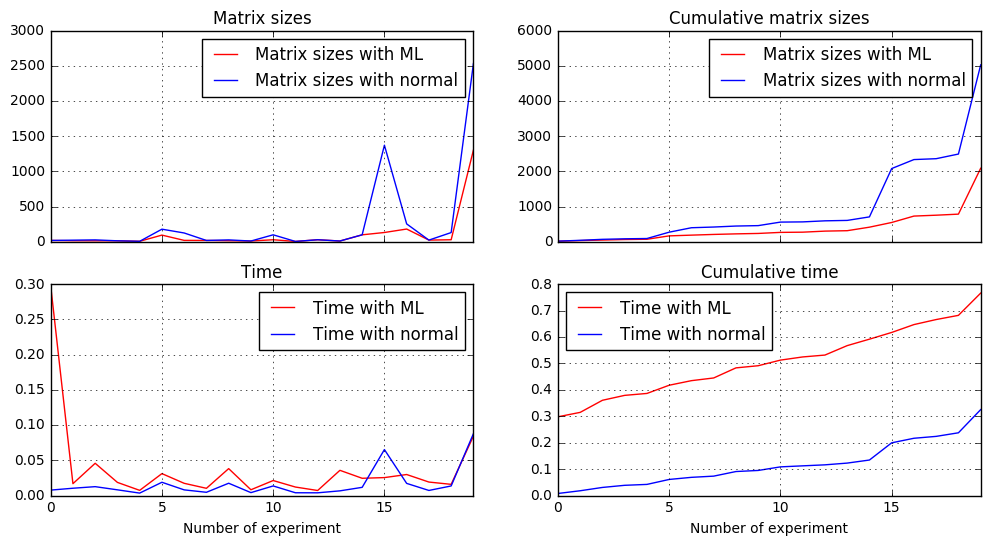

In [68]:
DrawFrame(matrices, times)

In [69]:
%time matrices, times =  LaunchF4_time_and_matrix_sizes(100, 4, 5, 5, 'normal', 'ML', clf, new_features = True)

Object No:  0


Object No:  10


Object No:  20


Object No:  30


Object No:  40


Object No:  50


Object No:  60


Object No:  70


Object No:  80


Object No:  90



times when normal is better:  86
times when ML is better:  14

system where normal worked most slowly:  [2/17*x0^3*x2 + 2*x0*x1*x2^2 + 323*x1*x2^3 + 3*x1^2*x2, 2/3*x0^2*x1 - 1/2*x2^3 + 2*x0^2 - 13*x0*x2, -6*x0^2*x1 - 3*x1^2*x2 - 9/62*x0*x1 - 6*x1^2 + 1/10*x1*x2]

system where ML worked most slowly:  [2/17*x0^3*x2 + 2*x0*x1*x2^2 + 323*x1*x2^3 + 3*x1^2*x2, 2/3*x0^2*x1 - 1/2*x2^3 + 2*x0^2 - 13*x0*x2, -6*x0^2*x1 - 3*x1^2*x2 - 9/62*x0*x1 - 6*x1^2 + 1/10*x1*x2]


Mean matrix size:
normal :  861.72 ,  ML :  258.96
Max matrix size:
normal :  39060 ,  ML :  5166
Min matrix size:
normal :  6 ,  ML :  6


Mean time:
normal :  0.0886225295067 ,  ML :  0.058869433403
Max time:
normal :  4.80681610107 ,  ML :  0.387611865997
Min time:
normal :  0.00246119499207 ,  ML :  0.00629997253418
CPU times: user 13.1 s, sys: 218 ms, total: 13.3 s
Wall time: 14.9 s


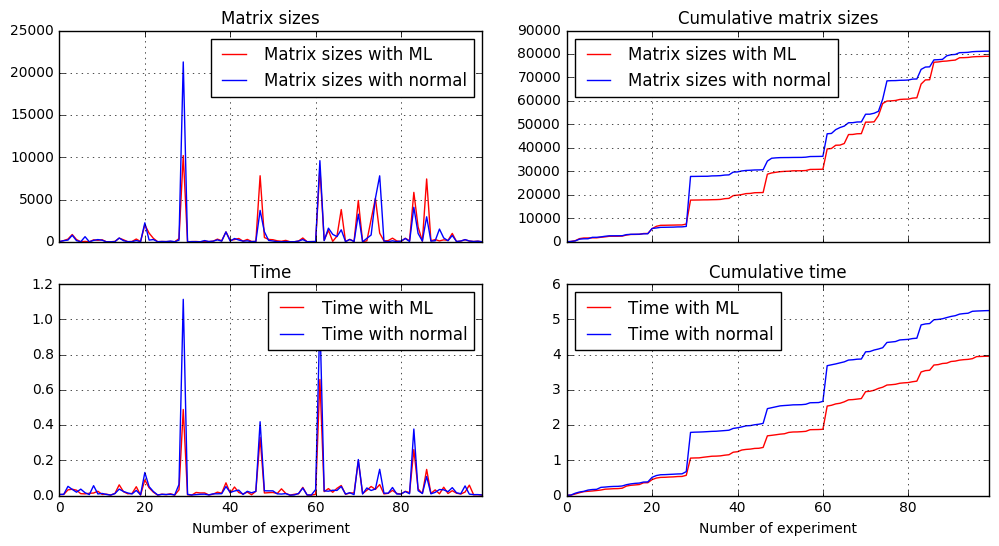

In [232]:
DrawFrame(matrices, times)

In [80]:
%time matrices, times =  LaunchF4_time_and_matrix_sizes(100, 5, 5, 5, 'normal', 'ML', clf, new_features=True)

Object No:  0


Object No:  10


Object No:  20


Object No:  30


Object No:  40


Object No:  50


Object No:  60


Object No:  70


Object No:  80


Object No:  90



times when normal is better:  73
times when ML is better:  27

system where normal worked most slowly:  [-x0*x1 + 3*x2^2 + 1/2*x2*x3 + 4/3*x3^2 + 1/3, -x0*x1*x2^2 + 2/15*x0*x2^2 + 15*x1^2*x3 - 3*x1*x3, 2/5*x1^4 + x0^2*x3^2 + x1*x2*x3^2 + 1/7*x0^2*x1 + 5/2*x0^2*x2, -29/8*x1^4 - 1/7*x2^3 + 2/3*x0*x2]

system where ML worked most slowly:  [-x0*x1 + 3*x2^2 + 1/2*x2*x3 + 4/3*x3^2 + 1/3, -x0*x1*x2^2 + 2/15*x0*x2^2 + 15*x1^2*x3 - 3*x1*x3, 2/5*x1^4 + x0^2*x3^2 + x1*x2*x3^2 + 1/7*x0^2*x1 + 5/2*x0^2*x2, -29/8*x1^4 - 1/7*x2^3 + 2/3*x0*x2]


Mean matrix size:
normal :  41773.23 ,  ML :  2909.23
Max matrix size:
normal :  2744205 ,  ML :  74046
Min matrix size:
normal :  8 ,  ML :  6


Mean time:
normal :  5.0544024992 ,  ML :  0.579674530029
Max time:
normal :  402.016227007 ,  ML :  39.1052691936
Min time:
normal :  0.00325393676758 ,  ML :  0.00663280487061
CPU times: user 8min 58s, sys: 2.83 s, total: 9min 1s
Wall time: 9min 23s


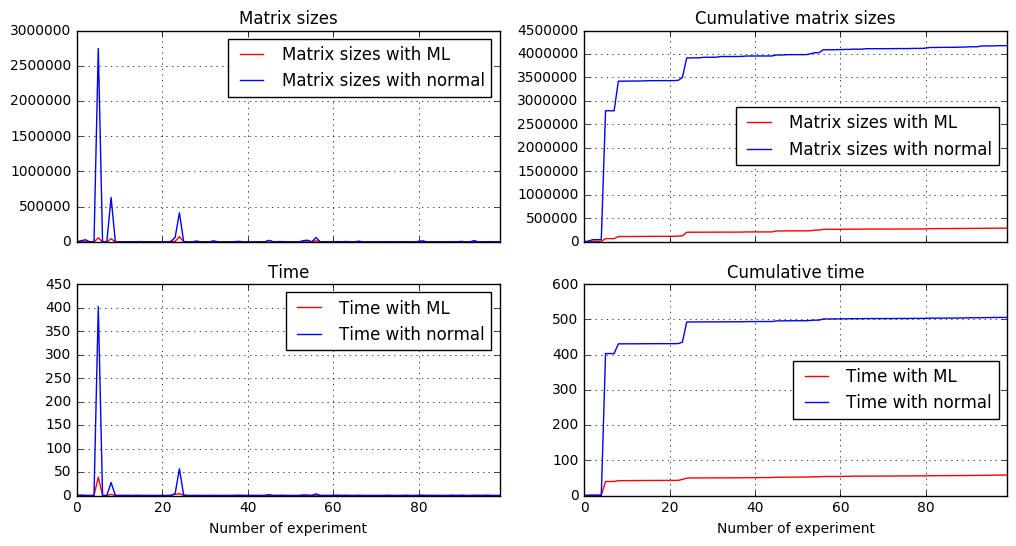

In [81]:
DrawFrame(matrices, times)

## Эксперименты со старыми и новыми признаками

In [82]:
input1 = open('X_train_444_19.pkl', 'rb')
X_train_old = pickle.load(input1)
input1.close()

input2 = open('y_train_444_19.pkl', 'rb')
y_train_old = pickle.load(input2)
input2.close()

In [83]:
clfOld = SVC(kernel = 'rbf', probability = True)
clfOld.fit(X_train_old, y_train_old)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [84]:
input1 = open('X_train_new_scaler.pkl', 'rb')
X_train_new = pickle.load(input1)
input1.close()

input2 = open('y_train_new_scaler.pkl', 'rb')
y_train_new = pickle.load(input2)
input2.close()

In [85]:
scaler = preprocessing.StandardScaler().fit(X_train_new)
X_train_new = scaler.transform(X_train_new)

clfNew = SVC(kernel = 'rbf', probability = True)
clfNew.fit(X_train_new, y_train_new)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [86]:
set_verbose(0)
%time matrices, times = LaunchF4_old_and_new_features(n=20, maxVar=4, maxElem=4, maxDeg=4, \
                                    stratOne='normal', stratTwo='MLold', stratThree='MLnew', clfOld=clfOld, clfNew=clfNew)

Object No:  0
Object No:  1
Object No:  2


Object No:  3
Object No:  4
Object No:  5
Object No:  6
Object No:  7
Object No:  8
Object No:  9
Object No:  10


Object No:  11
Object No:  12
Object No:  13
Object No:  14
Object No:  15
Object No:  16


Object No:  17
Object No:  18
Object No:  19


Mean matrix size:
normal: 130.5, MLold: 107.35, MLnew: 59.1


Max matrix size:
normal: 527, MLold: 416, MLnew: 195


Mean time:
normal: 0.0140971899033, MLold: 0.00836266279221, MLnew: 0.0174575209618


Max time:
normal: 0.0469238758087, MLold: 0.0255818367004, MLnew: 0.0852689743042
CPU times: user 666 ms, sys: 44.3 ms, total: 710 ms
Wall time: 836 ms


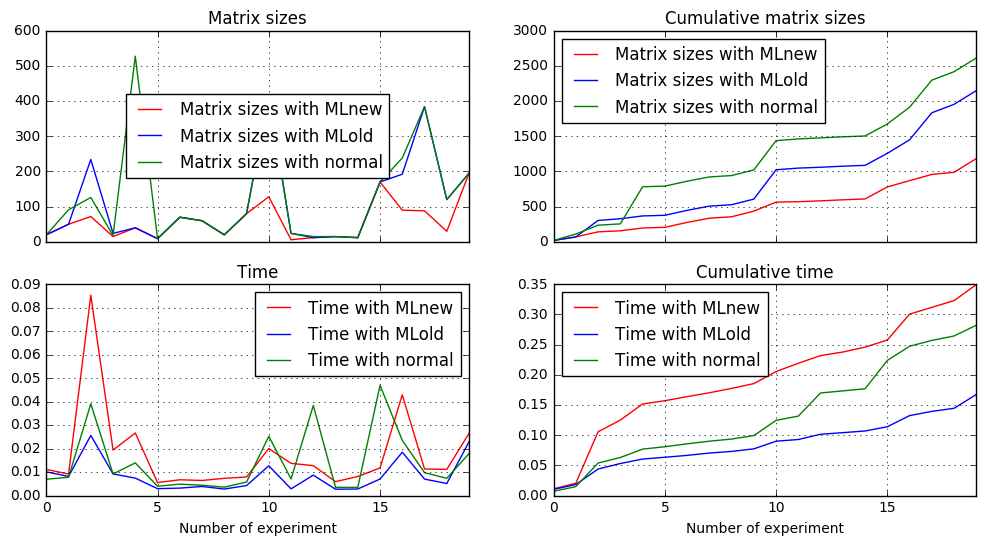

In [87]:
DrawFrame(matrices, times)

In [88]:
set_verbose(0)
%time matrices, times = LaunchF4_old_and_new_features(n=20, maxVar=4, maxElem=4, maxDeg=5, \
                                    stratOne='normal', stratTwo='MLold', stratThree='MLnew', clfOld=clfOld, clfNew=clfNew)

Object No:  0
Object No:  1
Object No:  2


Object No:  3
Object No:  4
Object No:  5


Object No:  6
Object No:  7
Object No:  8
Object No:  9
Object No:  10


Object No:  11
Object No:  12
Object No:  13


Object No:  14
Object No:  15
Object No:  16


Object No:  17
Object No:  18


Object No:  19


Mean matrix size:
normal: 698.15, MLold: 461.8, MLnew: 131.3


Max matrix size:
normal: 5332, MLold: 5332, MLnew: 546


Mean time:
normal: 0.029910326004, MLold: 0.0241344332695, MLnew: 0.0345083713531


Max time:
normal: 0.0782752037048, MLold: 0.0664169788361, MLnew: 0.11305308342
CPU times: user 1.59 s, sys: 60.4 ms, total: 1.65 s
Wall time: 1.87 s


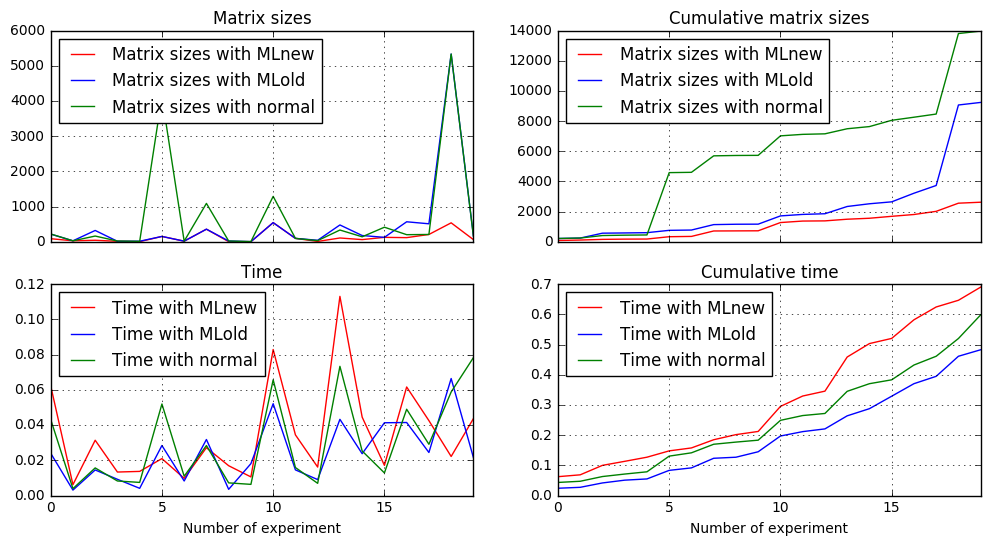

In [89]:
DrawFrame(matrices, times)

In [93]:
%time matrices, times = LaunchF4_old_and_new_features(n=20, maxVar=5, maxElem=5, maxDeg=5, \
                                    stratOne='normal', stratTwo='MLold', stratThree='MLnew', clfOld=clfOld, clfNew=clfNew)

Object No:  0
Object No:  1
Object No:  2


Object No:  3


Object No:  4
Object No:  5


Object No:  6


Object No:  7
Object No: 

 8
Object No:  9
Object No:  10
Object No:  11
Object No:  12


Object No:  13
Object No:  14
Object No:  15
Object No:  16


Object No:  17
Object No:  18


Object No:  19


Mean matrix size:
normal: 379133.15, MLold: 37323.4, MLnew: 32130.95


Max matrix size:
normal: 7555950, MLold: 711633, MLnew: 627120


Mean time:
normal: 47.4043319225, MLold: 0.827933108807, MLnew: 0.841148281097


Max time:
normal: 945.912244081, MLold: 15.1089220047, MLnew: 14.7767968178
CPU times: user 15min 32s, sys: 6.29 s, total: 15min 39s
Wall time: 16min 21s


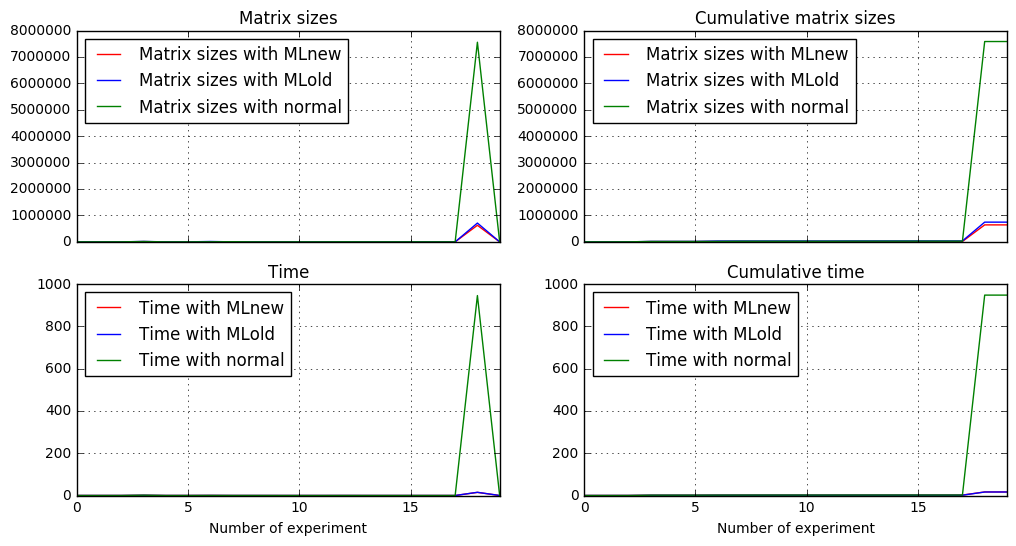

In [94]:
DrawFrame(matrices, times)

Видно, что новые признаки не сделали стратегию выигрышнее. Дело может быть в их неэффективном вычислении или просто в том, что следовало бы иначе производить отбор.

## CyclicN

Запустим F4 со стратегиями normal и ML на CyclicN. В обучающую выборку включалось 200 S-пар, возникающих в процессе решения случайно сгенерированных систем, а все остальные рассматриваемые S-пары были получены в процессе решения систем CyclicN.

In [257]:
def CreateDataSetForNewStrategyCyclic(approximateNumOfObjects, cyclicN, maxVar, maxElem, maxDeg, minVar = 1, minElem = 2,  minDeg = 1, new_features = False):
    allFeatures = []
    shouldBeTaken = []
    while len(allFeatures) < approximateNumOfObjects:
        print "Current number of objects: ", len(allFeatures)
        generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg, minVar, minElem,  minDeg)
        while 0 in generators or is_groebner_basis(generators):
            generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg, minVar, minElem,  minDeg)
        F4_data_NP(generators, allFeatures, shouldBeTaken, approximateNumOfObjects, new_features)
    approximateNumOfObjects += 7000
    for i in range(2, cyclicN + 1):
        P = PolynomialRing(QQ, 'x', i)
        I = sage.rings.ideal.Cyclic(P)
        generators = I.gens()
        print generators
        F4_data_NP(generators, allFeatures, shouldBeTaken, approximateNumOfObjects, new_features)
    return np.array(allFeatures), np.array(shouldBeTaken)

In [265]:
%time X_cyclic, y_cyclic = CreateDataSetForNewStrategyCyclic(approximateNumOfObjects = 200, cyclicN = 5, maxVar = 4, maxElem = 4, maxDeg = 4)

Current number of objects:  0
Current number of objects:  3
Current number of objects:  19
Current number of objects:  21
Current number of objects:  23
Current number of objects:  41
Current number of objects: 

 42
Current number of objects:  43
Current number of objects:  65
Current number of objects:  66


Current number of objects:  96
Current number of objects:  100
Current number of objects:  103
Current number of objects:  115
Current number of objects:  119
Current number of objects:  125
Current number of objects:  133
Current number of objects:  142
Current number of objects:  144
Current number of objects:  147
Current number of objects:  150
Current number of objects:  153
Current number of objects:  156
Current number of objects:  159


Current number of objects:  194
Current number of objects:  197
[x0 + x1, x0*x1 - 1]
[x0 + x1 + x2, x0*x1 + x0*x2 + x1*x2, x0*x1*x2 - 1]
[x0 + x1 + x2 + x3, x0*x1 + x1*x2 + x0*x3 + x2*x3, x0*x1*x2 + x0*x1*x3 + x0*x2*x3 + x1*x2*x3, x0*x1*x2*x3 - 1]


[x0 + x1 + x2 + x3 + x4, x0*x1 + x1*x2 + x2*x3 + x0*x4 + x3*x4, x0*x1*x2 + x1*x2*x3 + x0*x1*x4 + x0*x3*x4 + x2*x3*x4, x0*x1*x2*x3 + x0*x1*x2*x4 + x0*x1*x3*x4 + x0*x2*x3*x4 + x1*x2*x3*x4, x0*x1*x2*x3*x4 - 1]


CPU times: user 1min 8s, sys: 586 ms, total: 1min 9s
Wall time: 1min 13s


#### Cyclic 5

In [83]:
P = PolynomialRing(QQ, 'x', 5)
I = sage.rings.ideal.Cyclic(P)
I.gens()

// sage858 ideal 


[x0 + x1 + x2 + x3 + x4, x0*x1 + x1*x2 + x2*x3 + x0*x4 + x3*x4, x0*x1*x2 + x1*x2*x3 + x0*x1*x4 + x0*x3*x4 + x2*x3*x4, x0*x1*x2*x3 + x0*x1*x2*x4 + x0*x1*x3*x4 + x0*x2*x3*x4 + x1*x2*x3*x4, x0*x1*x2*x3*x4 - 1]

Нормальная стратегия:

In [264]:
set_verbose(0)
%time basis = F4_ML(I.gens(), 'normal', clf, new_features = False)

CPU times: user 2.55 s, sys: 4.13 ms, total: 2.55 s
Wall time: 3.03 s


ML:

In [88]:
input1 = open('X_cyclic_old_feat_cyc4.pkl', 'rb')
X_cyclic = pickle.load(input1)
input1.close()

input2 = open('y_cyclic_old_feat_cyc4.pkl', 'rb')
y_cyclic = pickle.load(input2)
input1.close()

In [81]:
clf = SVC(kernel = 'rbf')#, probability = True)
clf.fit(X_cyclic, y_cyclic)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [262]:
%time basis = F4_ML(I.gens(), 'ML', clf, new_features = False)

CPU times: user 2.55 s, sys: 32 ms, total: 2.58 s
Wall time: 2.73 s


In [49]:
ideal(basis[0]).basis_is_groebner()

// ** right side is not a datum, assignment ignored
// ** in line >>def sage576=option(sage575);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage578=option(sage577);<<


True

### Cyclic 6

In [166]:
P = PolynomialRing(QQ, 'x', 6)
I = sage.rings.ideal.Cyclic(P)
I.gens()b

[x0 + x1 + x2 + x3 + x4 + x5, x0*x1 + x1*x2 + x2*x3 + x3*x4 + x0*x5 + x4*x5, x0*x1*x2 + x1*x2*x3 + x2*x3*x4 + x0*x1*x5 + x0*x4*x5 + x3*x4*x5, x0*x1*x2*x3 + x1*x2*x3*x4 + x0*x1*x2*x5 + x0*x1*x4*x5 + x0*x3*x4*x5 + x2*x3*x4*x5, x0*x1*x2*x3*x4 + x0*x1*x2*x3*x5 + x0*x1*x2*x4*x5 + x0*x1*x3*x4*x5 + x0*x2*x3*x4*x5 + x1*x2*x3*x4*x5, x0*x1*x2*x3*x4*x5 - 1]

Нормальная стратегия:

In [51]:
set_verbose(1)
%time basis = F4_ML(I.gens(), 'normal', clf, new_features = False)

verbose 1 (multimod echelon) Multimodular echelon algorithm on 3 x 13 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 15 x 35 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 36 x 63 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 67 x 102 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 142 x 183 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 

verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 234 x 271 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 424 x 387 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 590 x 463 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 65 x 90 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 177 x 169 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 353 x 267 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 526 x 359 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 718 x 463 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 886 x 537 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 1478 x 734 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 95 x 98 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 218 x 187 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 346 x 314 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 409 x 378 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 368 x 342 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 381 x 343 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 1786 x 883 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 1847 x 1122 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 1521 x 1153 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 1497 x 1362 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 1067 x 1060 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (multimod echelon) Multimodular echelon algorithm on 939 x 959 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


CPU times: user 1min 32s, sys: 827 ms, total: 1min 32s
Wall time: 1min 43s


ML:

In [167]:
input1 = open('X_cyclic_19_old_feat.pkl', 'rb')
X_cyclic = pickle.load(input1)
input1.close()

input2 = open('y_cyclic_19_old_feat.pkl', 'rb')
y_cyclic = pickle.load(input2)
input1.close()

In [168]:
X_cyclic.shape

(6679, 19)

In [169]:
clf = SVC(kernel = 'rbf')#, probability = True)
clf.fit(X_cyclic, y_cyclic)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [170]:
set_verbose(1)
#%prun -s cumulative basis = F4_ML(I.gens(), 'ML', clf, new_features = False)
%time basis = F4_ML(I.gens(), 'ML', clf, new_features = False)

verbose 1 (multimod echelon) Multimodular echelon algorithm on 37 x 116 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage4340=option(sage4339);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage4342=option(sage4341);<<
verbose 1 (multimod echelon) Multimodular echelon algorithm on 13 x 33 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage4345=option(sage4344);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage4347=option(sage4346);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 39 x 62 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage4350=option(sage4349);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage4352=option(sage4351);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 84 x 101 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage4355=option(sage4354);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage4357=option(sage4356);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 194 x 197 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage4360=option(sage4359);<<


// ** right side is not a datum, assignment ignored
// ** in line >>def sage4362=option(sage4361);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 296 x 305 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage4365=option(sage4364);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage4367=option(sage4366);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 472 x 401 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage4370=option(sage4369);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage4372=option(sage4371);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 651 x 473 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage4375=option(sage4374);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage4377=option(sage4376);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 68 x 90 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage4380=option(sage4379);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage4382=option(sage4381);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 193 x 173 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage4385=option(sage4384);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage4387=option(sage4386);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 388 x 277 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage4390=option(sage4389);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage4392=option(sage4391);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 579 x 391 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage4395=option(sage4394);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage4397=option(sage4396);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 790 x 503 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage4400=option(sage4399);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage4402=option(sage4401);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 928 x 561 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage4405=option(sage4404);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage4407=option(sage4406);<<


verbose 1 (multimod echelon) Multimodular echelon algorithm on 1590 x 761 matrix


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


verbose 1 (sparse_matrix_pyx matrix_modint echelon) 


// ** right side is not a datum, assignment ignored
// ** in line >>def sage4410=option(sage4409);<<
// ** right side is not a datum, assignment ignored
// ** in line >>def sage4412=option(sage4411);<<


CPU times: user 40.3 s, sys: 432 ms, total: 40.8 s
Wall time: 46.1 s
